<a href="https://colab.research.google.com/github/diascarolina/project-energy-consumption-in-brazil/blob/main/notebooks/projeto_consumo_de_energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Técnico - 4intelligence

![](https://github.com/diascarolina/project-energy-consumption-in-brazil/blob/main/docs/banner.png?raw=true)

**Autor:** Carolina Araújo Dias

Reduzir custos para aumentar o lucro é um dos pilares da maioria das empresas existentes. No setor de energia elétrica, isso não seria diferente. Grandes indústrias do ramo de eletricidade buscam otimizar seus processos para a diminuição de desperdícios na produção.

É nesse contexto que se mostra relevante termos métodos e técnicas capazes de modelar com cada vez mais precisão o consumo de energia elétrica de diversos setores, como indústria, comércio e residencial, para que os processos de produção de energia se adequem às previsões e evitem gastos além do necessário e também o desperdício. [[1]](https://blog.bcntreinamentos.com.br/gestao-de-energia/amp/)

Estima-se que _"entre 2014 e 2016, o Brasil desperdiçou o equivalente a 1,4 vez a produção anual da usina hidrelétrica de Itaipu. É como se o país tivesse desprezado R$ 61,7 bilhões, já que essa energia não foi utilizada de forma produtiva."_ [Fonte: Indústria 4.0 pode mudar o cenário do consumo de energia no Brasil](https://valor.globo.com/google/amp/patrocinado/weg/weg/noticia/2019/08/05/industria-4-0-pode-mudar-o-cenario-do-consumo-de-energia-no-brasil.ghtml)

Com isso em mente, fica evidente que é necessário cada vez mais desenvolvermos novas técnicas para cessar esse desperdício não só monetário, mas até mesmo do próprio meio ambiente.

Com essa problematização, temos a tarefa de realizar exatamente isso: construir um modelo de aprendizagem de máquina para prever o futuro consumo de energia elétrica para que a oferta seja ajustada de acordo com a demanda. No caso do atual projeto, queremos **prever o consumo de energia elétrica da indústria na região sudeste do Brasil**.

# Bibliotecas e Configurações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import itertools
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
import missingno as msno # para visualizar os dados NaN

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from keras.models import Sequential
from keras.layers import LSTM, Dense
import xgboost as xgb
from xgboost import plot_importance, plot_tree

#!pip3 install lazypredict
from lazypredict.Supervised import LazyRegressor

import warnings
warnings.filterwarnings('ignore')

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# configurações para os gráficos
plt.style.use('seaborn-white')

rcParams['figure.figsize'] = 18, 8
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# cores para os gráficos
BLUE1 = '#0E4E9C' # Easter Egg: essa cor foi retirada do logo da 4intelligence :)

# Análise dos Dados

Os dados fornecidos contém informações sobre o consumo de energia de cada região do Brasil, além de inúmeras outras informações complementares relevantes, como a temperatura mínima, máxima e a produção industrial de cada região.

Os dados sobre consumo vão até Fevereiro de 2021, enquanto os outros dados vão até dezembro de 2022. Isso será relevante na hora de aplicarmos os modelos de Machine Learning para previsão em séries temporais.

Os dados originais podem ser encontrados [aqui](https://github.com/diascarolina/project-energy-consumption-in-brazil/blob/main/data/Bases_Final_ADS_Jun2021.xlsx).

Como a região que estávamos analisando é a sudeste, durante o projeto separei as variáveis relevantes à tal região, para termos um menor número de features para analisar, principalmente por questão de tempo.

Os dados também passaram pela seguinte divisão:

Dados de treino: vão desde o início do dataset, em janeiro de 2004 até Dezembro de 2017.

Dados de teste: Janeiro de 2018 a Fevereiro de 2021.

Dados para a previsão: Março de 2021 a dezembro de 2022.

In [104]:
# importação dos dados
url_dados = 'https://github.com/diascarolina/project-energy-consumption-in-brazil/blob/main/data/Bases_Final_ADS_Jun2021.xlsx?raw=true'

dados = pd.read_excel(url_dados, sheet_name = 'dados')

dicionario_dados = pd.read_excel(url_dados, sheet_name = 'dicionário')

In [105]:
# vamos dar uma olhada nesses dados
dados

,data_tidy,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,ind_se,res_co,res_n,res_ne,res_s,res_se,renda_r,pop_ocup_br,massa_r,du,pmc_a_co,temp_max_co,temp_min_co,pmc_r_co,pim_co,pmc_a_n,temp_max_n,temp_min_n,pmc_r_n,pim_n,pmc_a_ne,temp_max_ne,temp_min_ne,pmc_r_ne,pim_ne,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2004-01-01,307.28,193.81,589.29,704.00,2450.45,364.33,840.29,2015.78,1810.98,6977.47,506.54,348.58,1098.66,1132.51,3694.39,nan,75777.70,nan,21,41.45,31.34,22.25,45.71,59.00,32.41,31.98,23.35,39.58,65.25,36.61,30.41,23.43,38.82,87.80,49.49,28.32,19.17,54.85,78.50,50.76,27.62,20.37,47.37,75.45
1,2004-02-01,290.15,175.50,550.77,733.89,2396.97,372.65,810.26,1942.02,1931.87,7084.62,472.10,323.40,1000.22,1121.97,3511.54,nan,76464.33,nan,18,39.85,30.82,21.33,44.37,63.20,30.02,31.28,23.04,35.93,62.18,33.93,30.47,23.21,36.27,78.90,46.93,28.21,18.63,51.70,80.05,48.11,28.05,20.09,45.74,72.95
2,2004-03-01,307.10,182.76,573.03,738.46,2402.52,408.63,880.89,2082.25,2149.03,7087.61,493.18,320.24,1049.44,1108.03,3629.46,nan,75925.41,nan,23,46.24,31.65,21.14,50.43,70.50,33.29,31.58,23.25,39.12,76.73,39.01,30.93,23.44,40.18,88.10,54.56,27.60,17.85,57.36,95.78,54.13,28.18,19.75,49.25,83.94
3,2004-04-01,329.16,189.49,603.94,743.57,2580.91,419.43,861.61,2056.95,2164.76,7384.54,506.07,339.77,1097.25,1132.05,3733.86,nan,77102.27,nan,20,45.06,30.37,20.81,50.65,65.00,33.74,32.41,23.25,40.12,75.08,37.20,30.56,23.27,39.59,81.50,53.02,26.80,17.73,58.22,92.28,52.02,27.54,19.65,49.76,79.50
4,2004-05-01,303.24,191.64,570.18,696.58,2344.08,407.52,901.71,2100.19,2164.98,7258.31,492.81,332.15,1033.01,1082.10,3537.27,nan,77353.87,nan,21,47.72,25.49,16.87,53.66,73.70,37.34,31.82,22.54,45.13,75.82,40.03,30.37,22.74,42.35,85.20,54.86,20.62,12.61,60.44,92.55,54.35,25.39,17.57,51.85,84.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022-08-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2335.00,88772.84,201025.00,23,88.50,30.84,17.47,84.50,144.46,110.22,34.91,23.29,103.70,118.93,82.35,30.05,22.04,82.44,100.42,104.18,21.60,12.25,103.73,115.27,96.79,25.20,16.74,95.38,97.70
224,2022-09-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2332.00,89266.51,201387.00,21,85.71,32.91,20.08,83.18,135.82,103.86,35.22,24.22,99.08,118.49,77.36,30.92,22.88,79.05,99.04,100.06,23.28,14.71,101.39,106.29,92.42,27.31,18.59,92.16,93.30
225,2022-10-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2330.00,89857.40,201597.00,20,88.54,32.93,21.30,85.73,124.28,109.17,34.77,24.19,104.02,123.39,80.65,31.13,23.62,82.11,107.88,106.18,24.57,16.17,106.74,111.99,96.19,27.95,19.93,96.27,95.32
226,2022-11-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2327.00,90038.63,201815.00,20,91.49,30.92,21.12,90.45,101.07,113.67,33.86,24.18,110.22,118.45,86.80,31.96,24.43,90.34,104.45,110.43,25.86,17.15,112.68,107.77,100.28,27.29,19.92,101.64,87.86


In [106]:
# vamos dar uma olhado no dicionário dos dados
dicionario_dados.head()

,coluna,descrição
0,data_tidy,data dd-MM-AAA
1,com_co,Consumo de energia (Gwh) - Comércio - Região C...
2,com_n,Consumo de energia (Gwh) - Comércio - Região N...
3,com_ne,Consumo de energia (Gwh) - Comércio - Região N...
4,com_s,Consumo de energia (Gwh) - Comércio - Região S...


Como vemos acima, no dicionário temos a explicação de cada variável presente no dataset. Colocarei elas a seguir para facilitar a consulta futura:

- **data_tidy:** data no formato ```DD-MM-AAAA```
- **com_co:** Consumo de energia (Gwh) - Comércio - Região Centro Oeste - Fonte: EPE
- **com_n:** Consumo de energia (Gwh) - Comércio - Região Norte - Fonte: EPE
- **com_ne:** Consumo de energia (Gwh) - Comércio - Região Nordeste - Fonte: EPE
- **com_s:** Consumo de energia (Gwh) - Comércio - Região Sul - Fonte: EPE
- **com_se:** Consumo de energia (Gwh) - Comércio - Região Sudeste - Fonte: EPE
- **ind_co:** Consumo de energia (Gwh) - Indústria - Região Centro Oeste - Fonte: EPE
- **ind_n:** Consumo de energia (Gwh) - Indústria - Região Norte - Fonte: EPE
- **ind_ne:** Consumo de energia (Gwh) - Indústria - Região Nordeste - Fonte: EPE
- **ind_s:** Consumo de energia (Gwh) - Indústria - Região Sul - Fonte: EPE
- **ind_se:** Consumo de energia (Gwh) - Indústria - Região Sudeste - Fonte: EPE
- **res_co:** Consumo de energia (Gwh) - Residencial - Região Centro Oeste - Fonte: EPE
- **res_n:** Consumo de energia (Gwh) - Residencial - Região Norte - Fonte: EPE
- **res_ne:** Consumo de energia (Gwh) - Residencial - Região Nordeste - Fonte: EPE
- **res_s:** Consumo de energia (Gwh) - Residencial - Região Sul - Fonte: EPE
- **res_se:** Consumo de energia (Gwh) - Residencial - Região Sudeste - Fonte: EPE
- **renda_r:** Renda Real (Brasil) - Fonte: Pnad
pop_ocup_br	População Ocupada (Brasil) - Fonte: Pnad
- **massa_r:** Massa de Rendimento Real (Brasil) - Fonte: Pnad
- **du:** Dias úteis
- **pmc_a_co:** Pesquisa Mensal do Comércio Ampliada (Região Centro Oeste) - IBGE
- **temp_max_co:** Temperatura Máxima Mensal (Região Centro Oeste)
- **temp_min_co:** Temperatura Minima Mensal (Região Centro Oeste)
- **pmc_r_co:** Pesquisa Mensal do Comércio Restrita (Região Centro Oeste) - IBGE
- **pim_co:** Produção Industrial (Região Centro Oeste) - IBGE
- **pmc_a_n:** Pesquisa Mensal do Comércio Ampliada (Região Norte) - IBGE
- **temp_max_n:** Temperatura Máxima Mensal (Região Norte)
- **temp_min_n:** Temperatura Minima Mensal (Região Norte)
- **pmc_r_n:** Pesquisa Mensal do Comércio Restrita (Região Norte) - IBGE
- **pim_n:** Produção Industrial (Região Norte) - IBGE
- **pmc_a_ne:** Pesquisa Mensal do Comércio Ampliada (Região Nordeste) - IBGE
- **temp_max_ne:** Temperatura Máxima Mensal (Região Nordeste)
- **temp_min_ne:** Temperatura Minima Mensal (Região Nordeste)
- **pmc_r_ne:** Pesquisa Mensal do Comércio Restrita (Região Nordeste) - IBGE
- **pim_ne:** Produção Industrial (Região Nordeste) - IBGE
- **pmc_a_s:** Pesquisa Mensal do Comércio Ampliada (Região Sul) - IBGE
- **temp_max_s:** Temperatura Máxima Mensal (Região Sul)
- **temp_min_s:** Temperatura Minima Mensal (Região Sul)
- **pmc_r_s:** Pesquisa Mensal do Comércio Restrita (Região Sul) - IBGE
- **pim_s:** Produção Industrial (Região Sul) - IBGE
- **pmc_a_se:** Pesquisa Mensal do Comércio Ampliada (Região Sudeste) - IBGE
- **temp_max_se:** Temperatura Máxima Mensal (Região Sudeste)
- **temp_min_se:** Temperatura Minima Mensal (Região Sudeste)
- **pmc_r_se:** Pesquisa Mensal do Comércio Restrita (Região Sudeste) - IBGE
- **pim_se:** Produção Industrial (Região Sudeste) - IBGE

Vamos agora entender melhor os dados que temos em mãos.

In [107]:
print('Temos {} linhas e {} colunas nesse dataset.'.format(dados.shape[0], dados.shape[1]))

Temos 228 linhas e 45 colunas nesse dataset.


In [108]:
# informações dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data_tidy    228 non-null    datetime64[ns]
 1   com_co       206 non-null    float64       
 2   com_n        206 non-null    float64       
 3   com_ne       206 non-null    float64       
 4   com_s        206 non-null    float64       
 5   com_se       206 non-null    float64       
 6   ind_co       206 non-null    float64       
 7   ind_n        206 non-null    float64       
 8   ind_ne       206 non-null    float64       
 9   ind_s        206 non-null    float64       
 10  ind_se       206 non-null    float64       
 11  res_co       206 non-null    float64       
 12  res_n        206 non-null    float64       
 13  res_ne       206 non-null    float64       
 14  res_s        206 non-null    float64       
 15  res_se       206 non-null    float64       
 16  renda_r 

In [109]:
# contagem dos dados nulos
dados.isnull().sum()

data_tidy       0
com_co         22
com_n          22
com_ne         22
com_s          22
com_se         22
ind_co         22
ind_n          22
ind_ne         22
ind_s          22
ind_se         22
res_co         22
res_n          22
res_ne         22
res_s          22
res_se         22
renda_r        98
pop_ocup_br     0
massa_r        98
du              0
pmc_a_co        0
temp_max_co     0
temp_min_co     0
pmc_r_co        0
pim_co          0
pmc_a_n         0
temp_max_n      0
temp_min_n      0
pmc_r_n         0
pim_n           0
pmc_a_ne        0
temp_max_ne     0
temp_min_ne     0
pmc_r_ne        0
pim_ne          0
pmc_a_s         0
temp_max_s      0
temp_min_s      0
pmc_r_s         0
pim_s           0
pmc_a_se        0
temp_max_se     0
temp_min_se     0
pmc_r_se        0
pim_se          0
dtype: int64

Notamos que temos bastantes dados nulos. Vejamos isso graficamente a seguir.

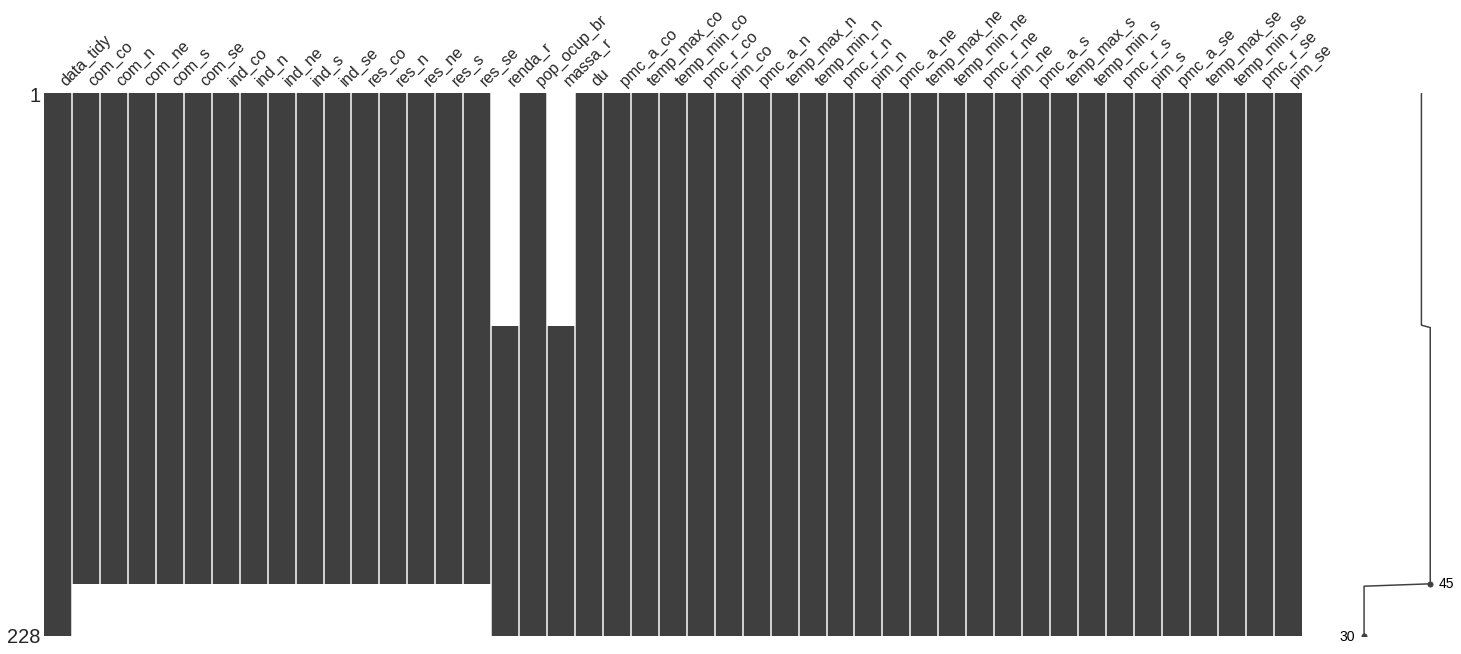

In [110]:
# visualização dos dados nulos
msno.matrix(dados)
plt.show()

Agora ficou fácil visualizar os valores faltantes. Não temos os valores iniciais em ```renda_r``` e ```massa_r``` que representam, respectivamente, a Renda Real do Brasil e a Massa de Rendimento Real do Brasil. Esses dados estão faltantes, provavelmente, porque só começaram a ser contabilizados a partir de Março de 2012.

Já os valores de consumo energético também possuem dados faltantes. Mas aqui não há problema, pois são esses os dados que queremos prever, a partir de Março de 2021.

Por agora, iremos substituir esses valores nulos em ```renda_r``` e ```massa_r``` por zero, mesmo não sendo o mais adequado. Mais adiante, analisaremos melhor a influência que esses dados tem na análise total.

In [111]:
dados[['renda_r', 'massa_r']] = dados[['renda_r', 'massa_r']].fillna(0)

Como estamos tratando região sudeste e principalmente por questão de tempo, irei avaliar as variáveis relacionadas à essa região.

In [112]:
colunas_se = ['data_tidy', 'com_se', 'ind_se', 'res_se', 'renda_r', 'massa_r',
              'pop_ocup_br', 'du', 'pmc_a_se', 'temp_max_se', 'temp_min_se',
              'pmc_r_se', 'pim_se']

In [113]:
# pegamos apenas os dados relacionados ao Sudeste
dados_se = dados[colunas_se]

# colocamos a data como índice do dataframe
dados_se = dados_se.set_index('data_tidy').rename_axis(None)

# vamos observar o dataframe
dados_se.head()

,com_se,ind_se,res_se,renda_r,massa_r,pop_ocup_br,du,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
2004-01-01,2450.45,6977.47,3694.39,0.00,0.00,75777.70,21,50.76,27.62,20.37,47.37,75.45
2004-02-01,2396.97,7084.62,3511.54,0.00,0.00,76464.33,18,48.11,28.05,20.09,45.74,72.95
2004-03-01,2402.52,7087.61,3629.46,0.00,0.00,75925.41,23,54.13,28.18,19.75,49.25,83.94
2004-04-01,2580.91,7384.54,3733.86,0.00,0.00,77102.27,20,52.02,27.54,19.65,49.76,79.50
2004-05-01,2344.08,7258.31,3537.27,0.00,0.00,77353.87,21,54.35,25.39,17.57,51.85,84.19


Agora vamos analisar essa colunas.

**Observação.** Todos os gráficos possuem o eixo y iniciando-se em 0. Isso ajuda a evitar distorções na visualização dos dados.

**Análise do Consumo de Energia (Gwh) - Comércio - Região Sudeste:** ```com_se```

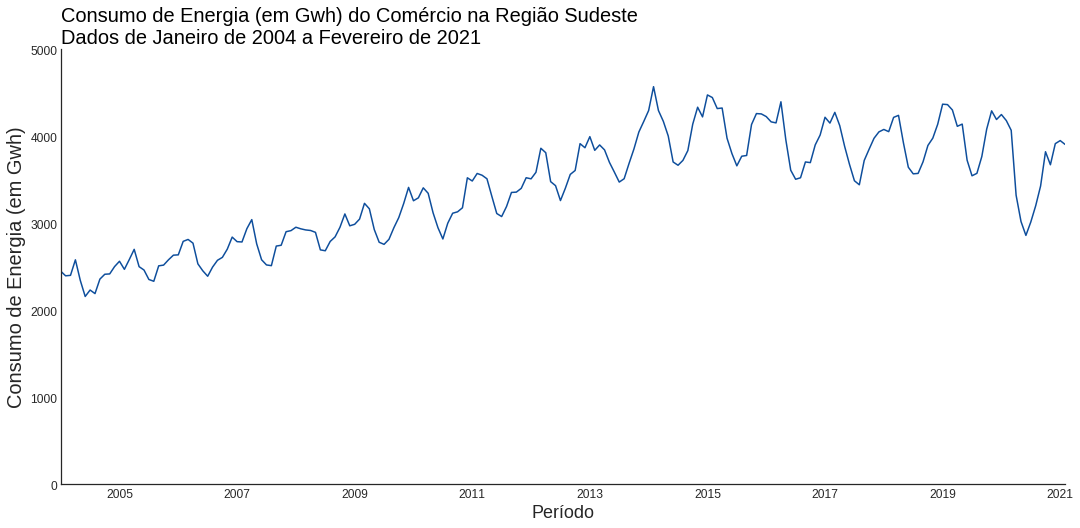

In [114]:
dados_se.com_se.loc[:'02-01-2021'].plot(color = BLUE1)
plt.title('Consumo de Energia (em Gwh) do Comércio na Região Sudeste\nDados de Janeiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
plt.ylabel('Consumo de Energia (em Gwh)', fontsize = 20)
sns.despine()
plt.ylim(0, 5000)
plt.show()

Fica claro que existe uma forte sazonalidade nessa série temporal do Consumo de Energia do Comércio no Sudeste e que há uma tendência de crescimento entre os anos.

**Análise do Consumo de Energia (Gwh) - Indústria - Região Sudeste:** ```ind_se```

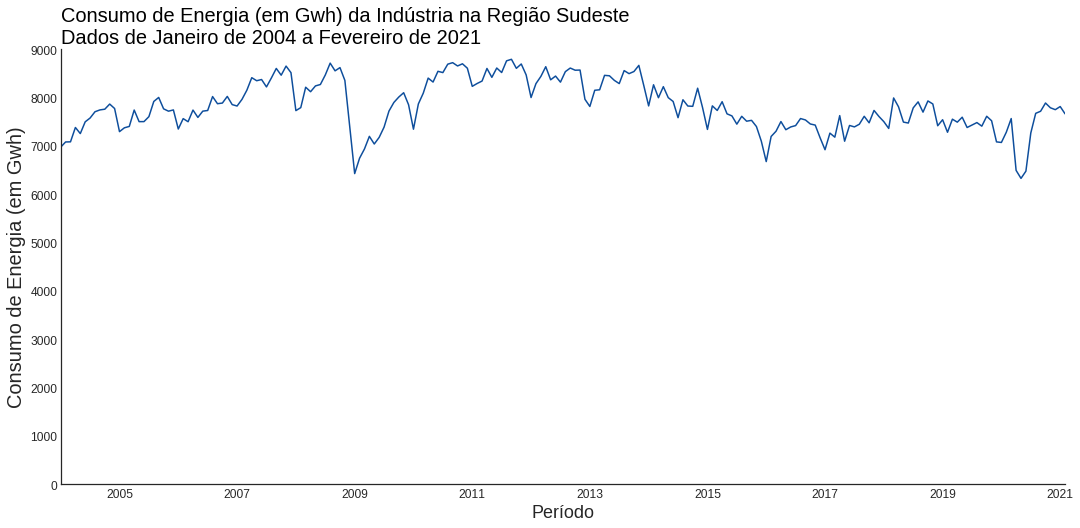

In [115]:
dados_se.ind_se.loc[:'02-01-2021'].plot(color = BLUE1)
plt.title('Consumo de Energia (em Gwh) da Indústria na Região Sudeste\nDados de Janeiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
plt.ylabel('Consumo de Energia (em Gwh)', fontsize = 20)
sns.despine()
plt.ylim(0, 9000)
plt.show()

Aqui temos a variável que queremos prever, o consumo de energia da indústria da região Sudeste. Já temos uma séria temporal menos comportada, com alguns altos e baixos mais acentuados nos picos, mas ainda sim com uma forte sazonalidade.

**Análise de Consumo de Energia (Gwh) - Residencial - Região Sudeste:** ```res_se```

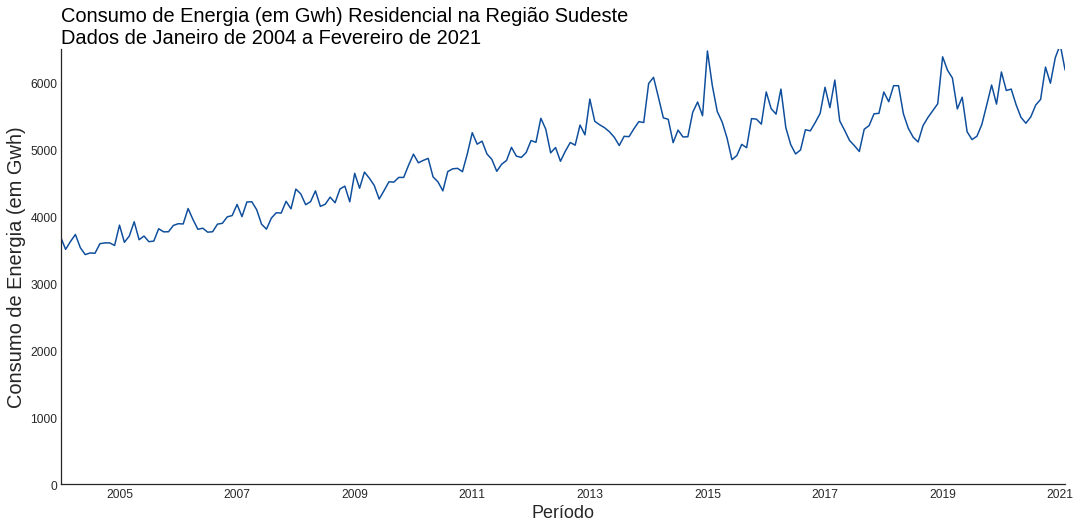

In [116]:
dados_se.res_se.loc[:'02-01-2021'].plot(color = BLUE1)
plt.title('Consumo de Energia (em Gwh) Residencial na Região Sudeste\nDados de Janeiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
plt.ylabel('Consumo de Energia (em Gwh)', fontsize = 20)
sns.despine()
plt.ylim(0, 6500)
plt.show()

Aqui fica bem evidente a tendência de aumento da série temporal. Novamente, é forte a sazonalidade no consumo de energia residencial.

**Análise da Renda Real & da Massa de Rendimento Real - Brasil:** ```renda_r``` & ```massa_r```

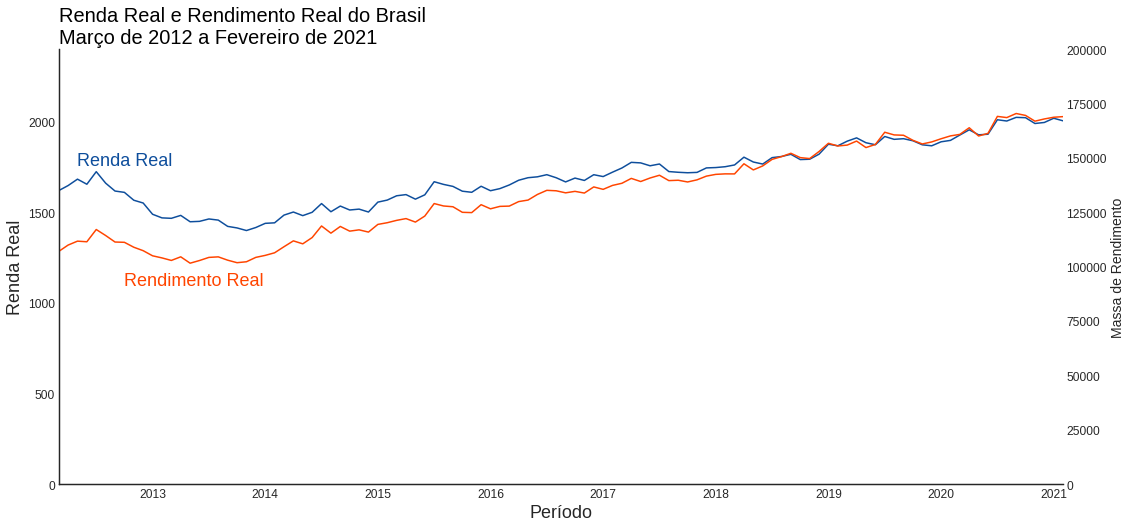

In [117]:
ax1 = dados_se.renda_r.loc['03-01-2012':'02-01-2021'].plot(color = BLUE1, label = 'Renda Real')
ax2 = ax1.twinx()
ax2 = dados_se.massa_r.loc['03-01-2012':'02-01-2021'].plot(color = 'orangered', label = 'Massa de Rendimento')
plt.title('Renda Real e Rendimento Real do Brasil\nMarço de 2012 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
ax1.set_ylabel('Renda Real', fontsize = 18)
ax2.set_ylabel('Massa de Rendimento')
ax1.set_xlabel('Período', fontsize = 18)
sns.despine()
ax1.set_ylim(0, 2400)
ax2.set_ylim(0, 200000)
ax1.text(508, 1760, 'Renda Real', color = BLUE1, fontsize = 18)
ax1.text(513, 1100, 'Rendimento Real', color = 'orangered', fontsize = 18)
plt.show()

Aqui temos a representação do crescimento da renda real do Brasil de Março de 2012 a Fevereiro de 2021. Percebemos que a sazonalidade não é tão forte.

**Análise da Pesquisa Mensal do Comércio Ampliada & Restrita - Região Sudeste:** ```pmc_a_se``` & ```pmc_r_se```

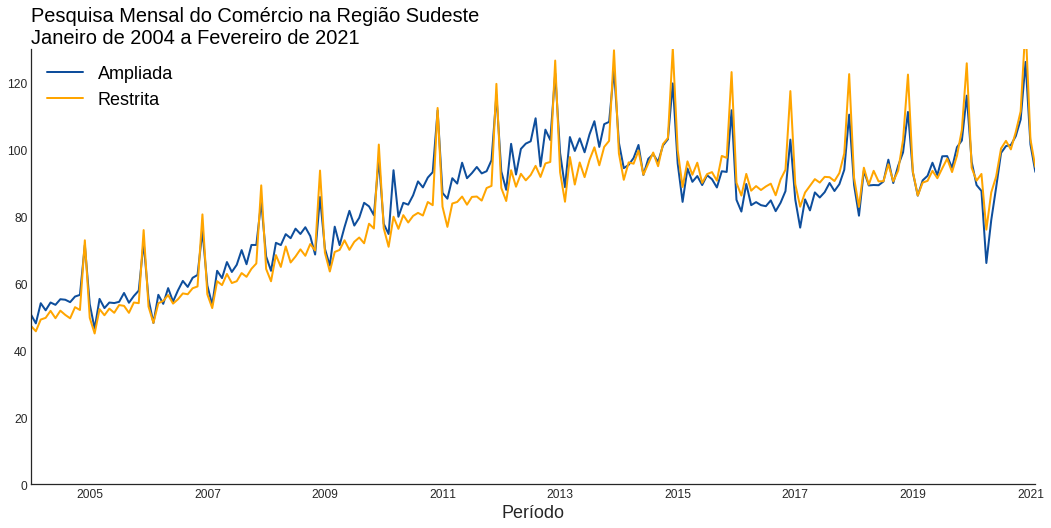

In [118]:
dados_se.pmc_a_se.loc[:'02-01-2021'].plot(color = BLUE1, label = 'Ampliada', linewidth = 2)
dados_se.pmc_r_se.loc[:'02-01-2021'].plot(color = 'orange', label = 'Restrita', linewidth = 2)
plt.title('Pesquisa Mensal do Comércio na Região Sudeste\nJaneiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
sns.despine()
plt.ylim(0, 130)
plt.legend(fontsize = 18)
plt.show()

Alta sazonalidade nessa série temporal, com picos de alta justamente no final dos anos, período mais aquecido para o comércio.

**Temperatura Máxima & Mínima - Região Sudeste:** ```temp_max_se``` & ```temp_min_se```

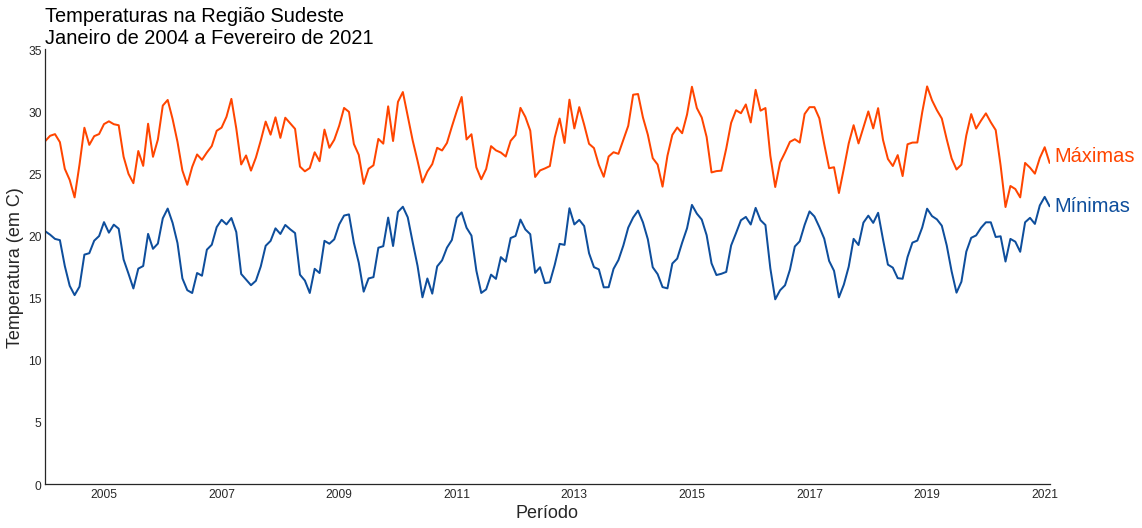

In [120]:
dados_se.temp_max_se.loc[:'02-01-2021'].plot(color = 'orangered', linewidth = 2)
dados_se.temp_min_se.loc[:'02-01-2021'].plot(color = BLUE1, linewidth = 2)
plt.title('Temperaturas na Região Sudeste\nJaneiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
plt.ylabel('Temperatura (em C)', fontsize = 18)
plt.text(614, 26, 'Máximas', color =  'orangered', fontsize = 20)
plt.text(614, 22, 'Mínimas', color = BLUE1, fontsize = 20)
sns.despine()
plt.ylim(0, 35)
plt.show()

Grande sazonalidade nas temperaturas, como era de se esperar.

Vamos observar a correlação entre as temperaturas e o consumo de energia da indústria no sudeste.

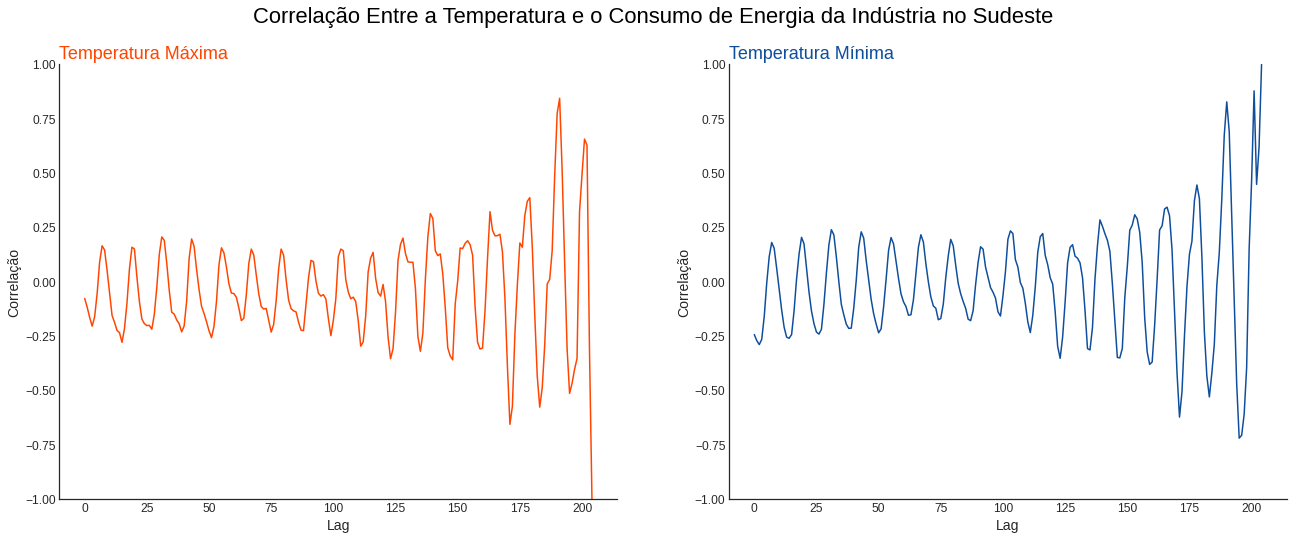

In [121]:
fig, axs = plt.subplots(1, 2, figsize = (22, 8))

correlacao_temp_max = [dados_se.ind_se.corr(dados_se.temp_max_se.shift(t)) for t in range(0, len(dados_se))]
correlacao_temp_min = [dados_se.ind_se.corr(dados_se.temp_min_se.shift(t)) for t in range(0, len(dados_se))]
lag = range(0, len(dados_se))

axs[0] = sns.lineplot(x = lag, y = correlacao_temp_max, color = 'orangered', ax = axs[0])
axs[1] = sns.lineplot(x = lag, y = correlacao_temp_min, color = BLUE1, ax = axs[1])

plt.suptitle('Correlação Entre a Temperatura e o Consumo de Energia da Indústria no Sudeste', fontsize = 22)
axs[0].set_title('Temperatura Máxima', loc = 'left', fontsize = 18, color = 'orangered')
axs[1].set_title('Temperatura Mínima', loc = 'left', fontsize = 18, color = BLUE1)
for i in [0, 1]:
    axs[i].set_ylim(-1, 1)
    axs[i].set_ylabel('Correlação')
    axs[i].set_xlabel('Lag')
sns.despine()

plt.show()

Vemos que há pouca correlação entre as temperaturas e o consumo de energia da indústria no sudeste, com os valores ficando geralmente entre 0.25 e -0.25. Como um lag de mais de 200 dias, esses valores tendem ao infinito e podem ser desconsiderado.

Como não há um efeito direto evidente da temperatura no consumo de energia da indústria na região sudeste, iremos dar menos importância a essa variável ao treinarmos os modelos.

**Produção Industrial - Região Sudeste:** ```pim_se```

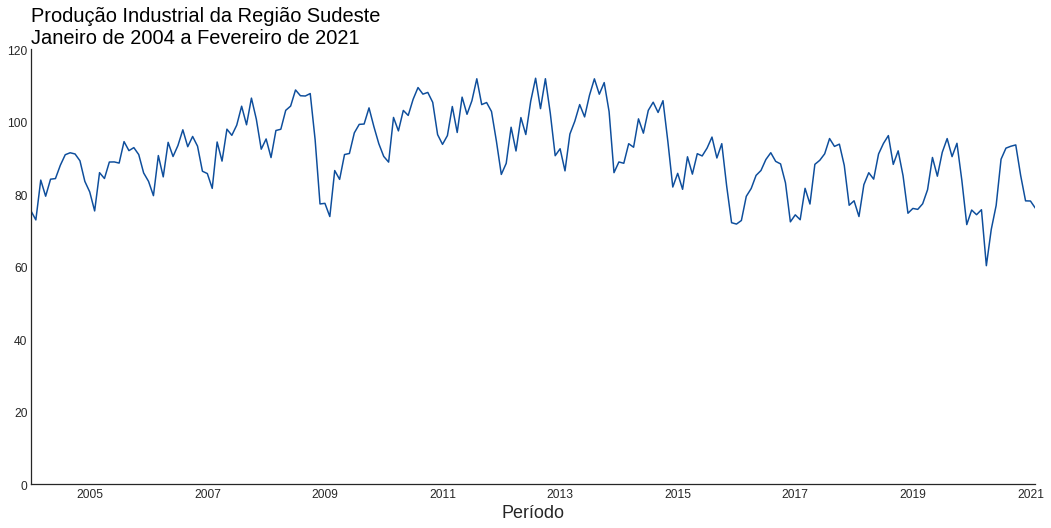

In [122]:
dados_se.pim_se.loc[:'02-01-2021'].plot(color = BLUE1)
plt.title('Produção Industrial da Região Sudeste\nJaneiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 20)
plt.xlabel('Período', fontsize = 18)
plt.ylim(0, 120)
sns.despine()
plt.show()

Há uma queda um pouco mais acentuada na produção industrial na região sudeste no início de 2009 e em meados de 2020.

A primeira se deu devido à crise econômica de 2008 que afetou diretamente a indústria. ([Fonte: A desindustrialização na região Sudeste](https://www.redalyc.org/jatsRepo/3073/307354691008/html/index.html))

Já a segunda queda mais acentuada deve-se à atual pandemia de Covid-19 que estamos enfrentando.

Creio que há uma grande relação entre a produção industrial e o consumo de energia, que é o que queremos prever. Vamos observar isso visualmente no gráfico a seguir.

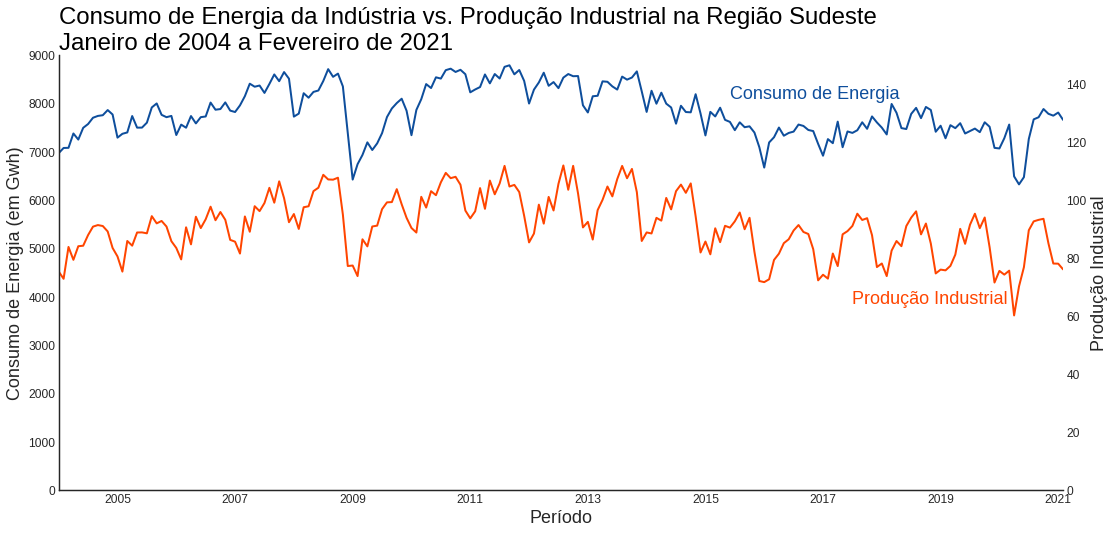

In [123]:
ax1 = dados_se.ind_se.plot(linewidth = 2, color = BLUE1)
ax2 = ax1.twinx()
ax2 = dados_se.pim_se.loc[:'02-01-2021'].plot(color = 'orangered', linewidth = 2)
plt.title('Consumo de Energia da Indústria vs. Produção Industrial na Região Sudeste\nJaneiro de 2004 a Fevereiro de 2021',
          loc = 'left', fontsize = 24)
ax1.set_xlabel('Período', fontsize  = 18)
ax1.set_ylabel('Consumo de Energia (em Gwh)', fontsize  = 18)
ax2.set_ylabel('Produção Industrial', fontsize  = 18)
ax1.set_ylim(0, 9000)
ax2.set_ylim(0, 150)
sns.despine()
ax1.text(545, 8100, 'Consumo de Energia', color = BLUE1, fontsize = 18)
ax1.text(570, 3850, 'Produção Industrial', color = 'orangered', fontsize = 18)
plt.show()

É evidente que existe uma grande relação entre a produção industrial e o consumo de energia da indústria, que é o que queremos prever. Como os dados da produção vão até Dezembro de 2022, eles serão essenciais na previsão do consumo de energia da indústria.

Podemos calcular a correlação entre essas séries temporais.

In [124]:
print('A correlação entre a série temporal do consumo de energia da indústria e a da produção industrial é de {:,.2f}.'.format(dados_se.ind_se.corr(dados_se.pim_se)))

A correlação entre a série temporal do consumo de energia da indústria e a da produção industrial é de 0.79.


In [125]:
print('A correlação entre a série temporal do consumo de energia da indústria e a da produção industrial com um atraso de um mês entre elas é de {:,.2f}.'.format(dados_se.ind_se.corr(dados_se.pim_se.shift(1))))

A correlação entre a série temporal do consumo de energia da indústria e a da produção industrial com um atraso de um mês entre elas é de 0.82.


Com essas informações vemos que há uma alta correlação entre as duas séries temporais e essa correlação aumenta após um mês de "shift" entre os dados.

Por último, vamos analisar a matriz de correlação das variáveis da região sudeste, para tentarmos entender melhor quais features utilizar nos modelos de Machine Learning.

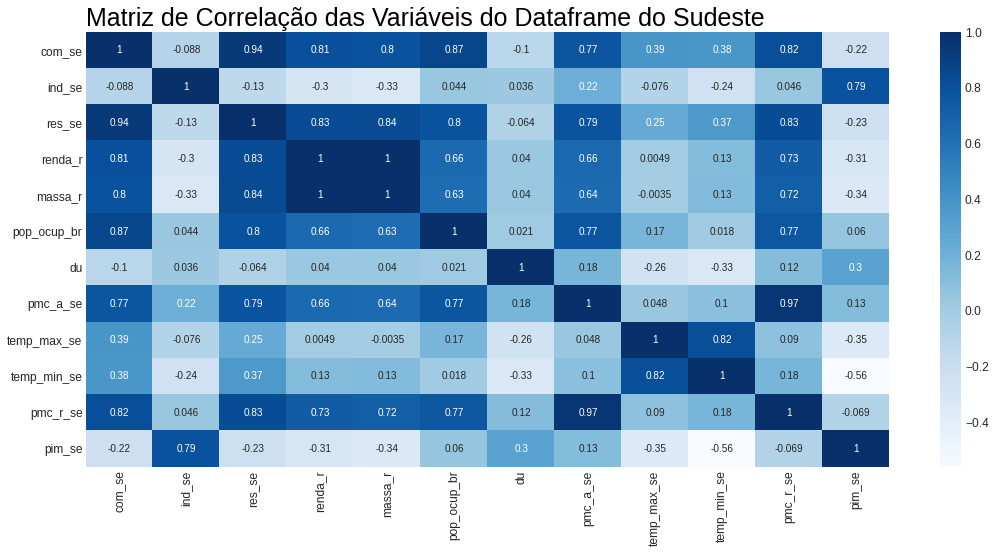

In [126]:
corr_matrix = dados_se.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')
plt.title('Matriz de Correlação das Variáveis do Dataframe do Sudeste', loc = 'left', fontsize = 25)
plt.show()

Como eu suspeitei, a variável mais significantemente correlacionada com o consumo de energia da indústria é justamente a produção industrial. As outras variáveis tem pouca correlação com a nossa target ```ind_se```.

# Modelos

Após analisarmos os dados, vemos que temos diversas séries temporais e nossas previsões se basearão nisso, na série temporal do consumo de energia da indústria da região sudeste.

Para séries temporais existem diversos modelos de Machine Learning mais apropriados que os modelos comuns de regressão, pois esses modelos vão levar em consideração a sazonalidade e o ruído da série temporal, por exemplo.

Além disso, como analisamos acima, a série temporal dos dados de consumo de energia da indústria está intimamente ligada à Produção Industrial da região Sudeste. Isso faz sentido, pois quanto maior for a produção industrial, maior também será o consumo de energia. (Sim, correlação não explica causalidade, mas nesse caso, com o nosso conhecimento sobre as variáveis, essa causalidade faz sentido).

Temos assim uma série temporal multivariada (que depende de outras variáveis) e iremos ver métodos próprios para esse caso também.

Separarei as informações em três partes:
- De Janeiro de 2004 até Dezembro de 2017 usarei como **dados de treino**;
- De Janeiro de 2008 até Fevereiro de 2021 usarei como **dados de teste**;
- De Março de 2021 até Dezembro de 2022 é o que **queremos prever**.

In [127]:
dados_se_treino = dados_se.loc[:'12-01-2017']
dados_se_teste = dados_se.loc['01-01-2018':'02-01-2021']
dados_se_previsao = dados_se.loc['03-01-2021':]

Se necessário para modelos supervisionados, vamos separar em ```X``` e ```y```, onde ```y``` é o consumo de energia da indústria no sudeste, a saber, ```ind_se```.

In [128]:
X_train = dados_se_treino.drop('ind_se', axis = 1)
y_train = dados_se_treino['ind_se']

X_test = dados_se_teste.drop('ind_se', axis = 1)
y_test = dados_se_teste['ind_se']

X_previsao = dados_se_previsao.drop('ind_se', axis = 1)
y_previsao = dados_se_previsao['ind_se']

## Modelo 00: Dummy Model

Uma boa prática para avaliarmos as métricas de modelos de Machine Learning é criar um modelo mais ingênuo possível que irá servir como uma base para as métricas dos modelos posteriores.

Pensei em fazer esse modelo "dummy" da seguinte forma: como a produção industrial tem tanta relação com o consumo de energia da indústria, podemos usar os valores da produção industrial para prever os valores do consumo de energia da indústria.

Mas há o problema da dimensionalidade dessas variáveis. Para resolver isso, irei escalar as variáveis, calcular as métricas e depois reescalá-las para o padrão anterior.

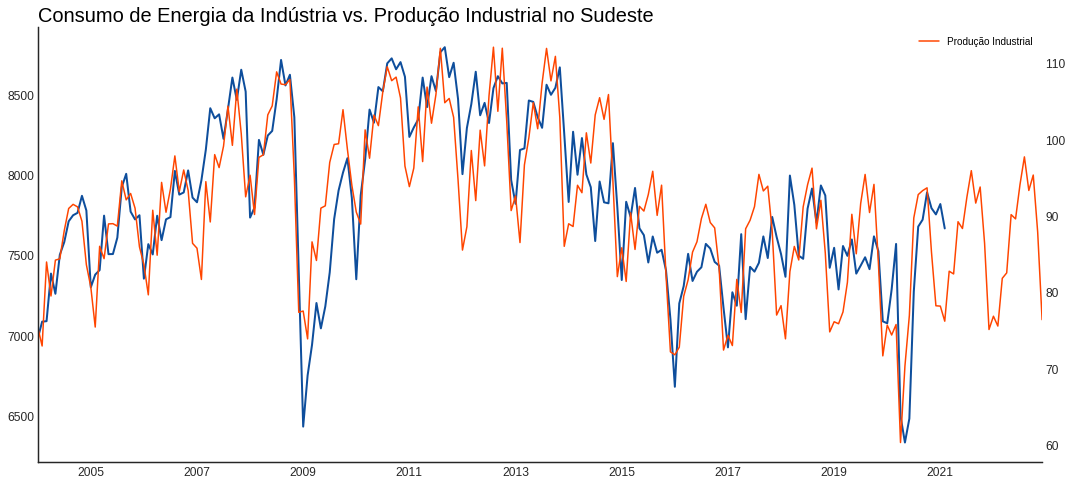

In [134]:
# um plot para conferir as séries temporais
ax1 = dados_se.ind_se.plot(color = BLUE1, label = 'Consumo de Energia', linewidth = 2)
ax2 = ax1.twinx()
ax2 = dados_se.pim_se.plot(color = 'orangered', label = 'Produção Industrial')
plt.title('Consumo de Energia da Indústria vs. Produção Industrial no Sudeste', loc = 'left', fontsize = 20)
sns.despine()
plt.legend()
plt.show()

In [135]:
dados_se_dummy = dados_se.copy()

# escalar as features
scaler_dummy_model = MinMaxScaler(feature_range = (0, 1))
dados_se_dummy['ind_se_scaled'] = scaler_dummy_model.fit_transform(dados_se_dummy['ind_se'].values.reshape(-1,1))
dados_se_dummy['pim_se_scaled'] = scaler_dummy_model.fit_transform(dados_se_dummy['pim_se'].values.reshape(-1,1))

In [136]:
# reescalar a produção industrial para a escala do consumo de energia
scaler_dummy_model = scaler_dummy_model.fit(dados_se_dummy['ind_se'].values.reshape(-1,1))
dados_se_dummy['ind_se_rescaled'] = scaler_dummy_model.inverse_transform(dados_se_dummy['ind_se_scaled'].values.reshape(-1,1))
dados_se_dummy['pim_se_rescaled'] = scaler_dummy_model.inverse_transform(dados_se_dummy['pim_se_scaled'].values.reshape(-1,1))

In [137]:
dados_se_dummy_treino = dados_se_dummy.loc[:'12-01-2017']
dados_se_dummy_teste = dados_se_dummy.loc['01-01-2018':'02-01-2021']
dados_se_dummy_previsao = dados_se_dummy.loc['03-01-2021':]

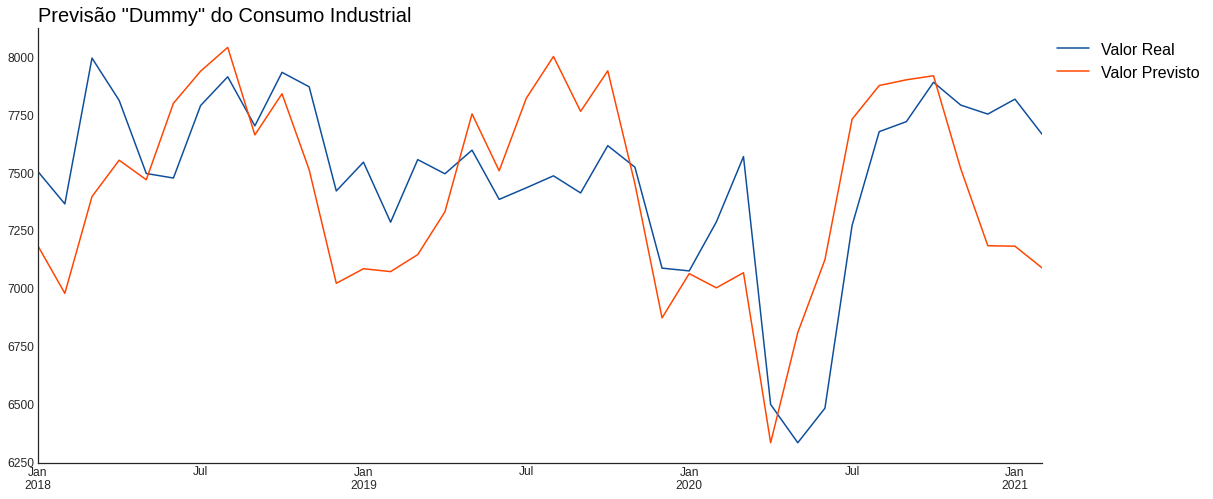

In [140]:
dados_se_teste.ind_se.plot(color = BLUE1, label = 'Valor Real')
dados_se_dummy_teste.pim_se_rescaled.plot(color = 'orangered', label = 'Valor Previsto')
plt.title('Previsão "Dummy" do Consumo Industrial', loc = 'left', fontsize = 20)
sns.despine()
plt.legend(fontsize = 16, bbox_to_anchor = (1, 1), loc = 'upper_left')
plt.show()

In [141]:
# cálculo das métricas utilizadas
mae_dummy = mean_absolute_error(dados_se_dummy_teste['pim_se_rescaled'], dados_se_dummy_teste['ind_se_rescaled'])
mse_dummy = mean_squared_error(dados_se_dummy_teste['pim_se_rescaled'], dados_se_dummy_teste['ind_se_rescaled'])
rmse_dummy = np.sqrt(mse_dummy)

print('MAE do Dummy Model: ', mae_dummy)
print('MSE do Dummy Model: ', mse_dummy)
print('RMSE do Dummy Model: ', rmse_dummy)

MAE do Dummy Model:  302.44372854145706
MSE do Dummy Model:  124692.91300461539
RMSE do Dummy Model:  353.1188369439039


## Modelo 01: SARIMA

Vamos tratar inicialmente a série temporal como uma série univariada para entendermos melhor seu comportamento.

Vamos primeiro decompor a série temporal do consumo de energia da indústria da região sudeste. Fazemos isso pra melhor analisar a série temporal e seus componentes, como o "trend", a sazonalidade e o ruído.

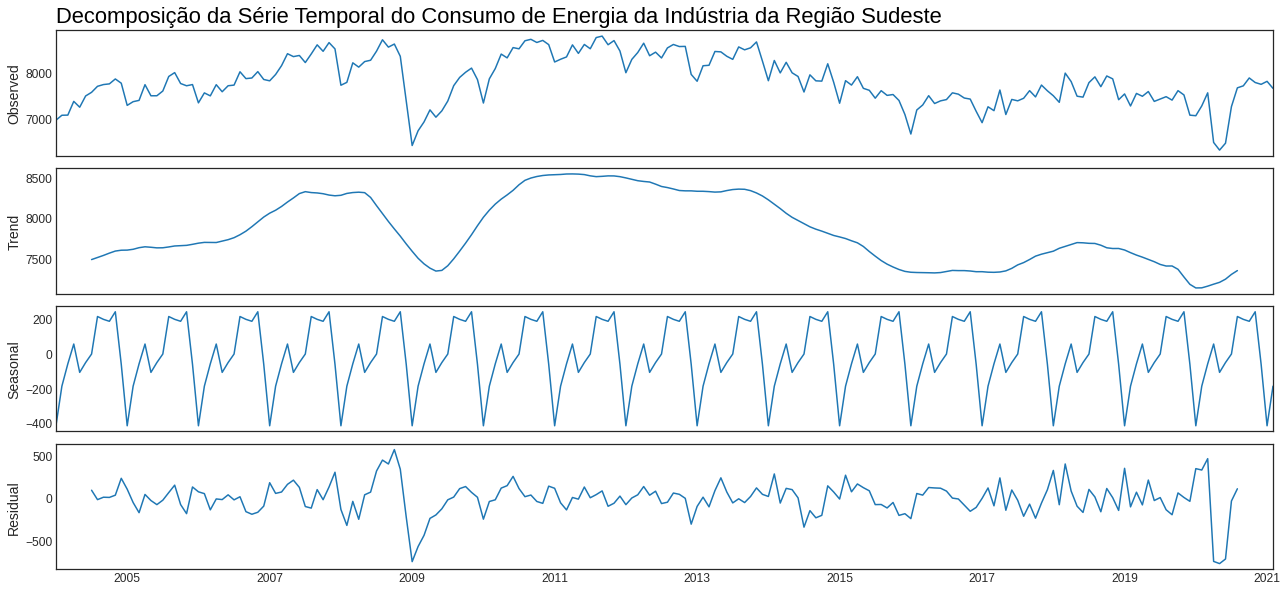

In [142]:
decomposition = sm.tsa.seasonal_decompose(dados_se.ind_se.loc[:'02-01-2021'], model = 'additive')
fig = decomposition.plot()
plt.text(408, 5600, 'Decomposição da Série Temporal do Consumo de Energia da Indústria da Região Sudeste', fontsize = 22)
plt.show()

O primeiro modelo aplicado será o ARIMA. Ele tem como parâmetros "p, q, d", que é a sazonalidade, o trend (a tendência), e os componentes aleatórios (o noise).

Usei a métrica AIC (Akaike Information Criterion) para calcular o melhor fit inicial para a série temporal. Queremos a seguir os parâmetros que dão o menor AIC.

In [143]:
# inicializa os parâmetros
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq_temporal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# testa toda as combinações dos parâmetros para escolhermos o melhor
for parametro in pdq:
    for param_temporal in pdq_temporal:
        mod = sm.tsa.statespace.SARIMAX(dados_se_treino.ind_se, order = parametro,
                                            seasonal_order = param_temporal, enforce_stationarity = False,
                                            enforce_invertibility = False)
            

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC: {}'.format(parametro, param_temporal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC: 3474.636286916518
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC: 3123.4516473390568
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC: 2370.5391582181046
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC: 2191.3621068987777
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC: 2386.9368858820185
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC: 2372.5804369719926
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC: 2208.25398944239
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC: 2177.4021005078353
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC: 3364.2889151591003
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC: 2837.7273276569376
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC: 2217.095143687975
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC: 2045.9488103929884
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC: 2247.571978296558
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC: 2218.8948066105163
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC: 2079.2011647300938
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC: 2035.6415010012547
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC: 2315.0043694436763
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

In [144]:
print('Melhor Parâmetro: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC: 1868.6380085951478')

Melhor Parâmetro: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC: 1868.6380085951478


In [145]:
# agora utilizarei o modelo no treino com esse parâmetro escolhido
modelo_arima = sm.tsa.statespace.SARIMAX(dados_se_treino.ind_se,
                                order = (0, 1, 1),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False,)
# fit no treino
resultados = modelo_arima.fit()

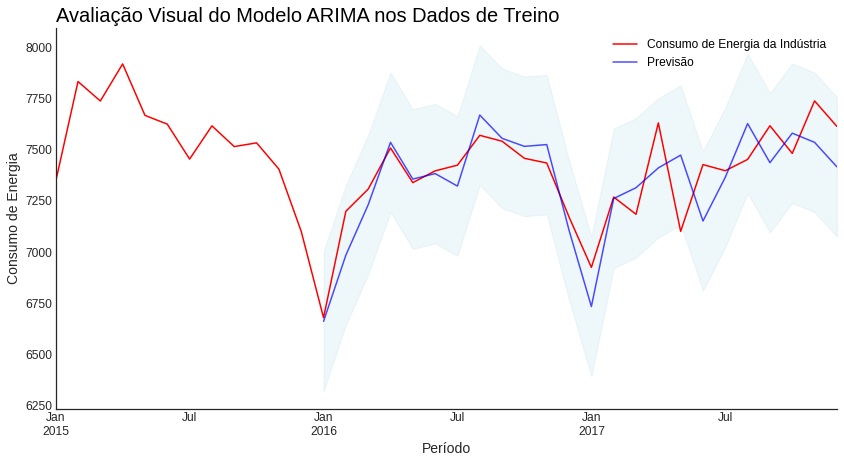

In [147]:
# previsão nos dados de treino
pred = resultados.get_prediction(start = pd.to_datetime('01-01-2016'), dynamic = False)
# intervalo de confiança
pred_ci = pred.conf_int()
# plot
ax = dados_se_treino.ind_se.loc['01-01-2015':].plot(label = 'Consumo de Energia da Indústria', color = 'r')
pred.predicted_mean.plot(ax = ax, label = 'Previsão', alpha = 0.7, figsize = (14, 7), color = 'b')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'lightblue', alpha = 0.2)
ax.set_xlabel('Período')
ax.set_ylabel('Consumo de Energia')
ax.set_title('Avaliação Visual do Modelo ARIMA nos Dados de Treino', loc = 'left', fontsize = 20)
sns.despine()
plt.legend(fontsize = 12)
plt.show()

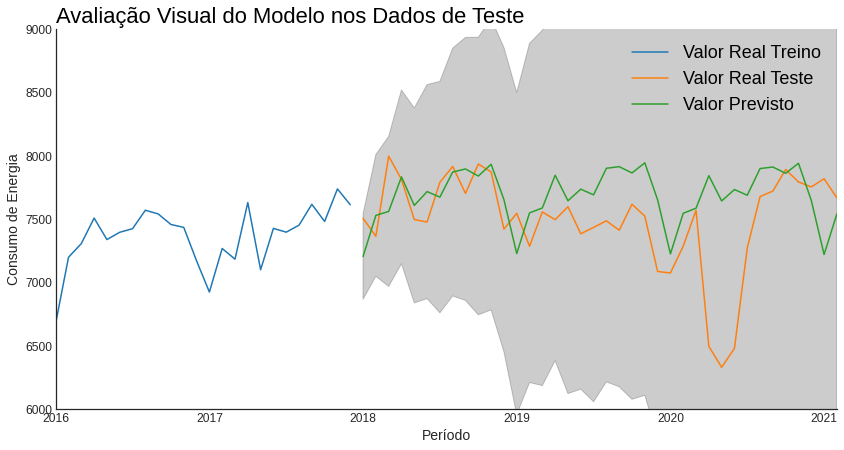

In [148]:
# previsao nos dados de teste
previsao_arima = results.get_forecast(steps = 38)
# intervalo de confiança
previsao_int_conf = previsao_arima.conf_int()
#plot
ax = dados_se_treino.ind_se.loc['01-01-2016':].plot(label = 'Valor Real Treino', figsize = (14, 7))
dados_se_teste.ind_se.plot(figsize = (14, 7), label = 'Valor Real Teste')
previsao_arima.predicted_mean.plot(ax = ax, label = 'Valor Previsto')
ax.fill_between(previsao_int_conf.index, previsao_int_conf.iloc[:, 0], previsao_int_conf.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel('Período')
ax.set_ylabel('Consumo de Energia')
ax.set_title('Avaliação Visual do Modelo nos Dados de Teste', loc = 'left', fontsize = 22)
sns.despine()
ax.set_ylim(6000, 9000)
plt.legend(fontsize = 18)
plt.show()

In [150]:
# cálculo das métricas utilizadas
y_previsto = previsao_arima.predicted_mean
y_real = dados_se_teste.ind_se
mae_sarima = mean_absolute_error(y_real, y_previsto)
mse_sarima = mean_squared_error(y_real, y_previsto)
rmse_sarima = np.sqrt(mse_sarima)

print('o Mean Absolute Error (MAE) da previsão SARIMA foi de {:,.2f}'.format(mae_sarima))
print('O Mean Squared Error (MSE) da previsão SARIMA foi de {:,.2f}'.format(mse_sarima))
print('O Root Mean Squared Error (RMSE) da previsão SARIMA foi de {:,.2f}'.format(round(rmse_sarima, 5)))

o Mean Absolute Error (MAE) da previsão SARIMA foi de 314.37
O Mean Squared Error (MSE) da previsão SARIMA foi de 205,634.48
O Root Mean Squared Error (RMSE) da previsão SARIMA foi de 453.47


**Conclusões:**
Esse modelo conseguiu capturar pouco do comportamento da série temporal, sem conseguir prever os períodos de baixa. Isso é explicado por não termos usado o produção industrial para ajudar a prever a série.

## Modelo 02: Prophet

Prophet é uma poderosa biblioteca do Facebook para previsão de séries temporais.

Vamos fazer aqui uma previsão multivariada, utilizando a produção da indústria para ajudar a prever o consumo de energia.

In [151]:
# preparando os dataframes, pois essa biblioteca requer os dados em um formato específico
dados_se2 = dados_se_treino.copy()
dados_se2['index1'] = dados_se2.index

dados_se2_teste = dados_se_teste.copy()
dados_se2_teste['index1'] = dados_se2_teste.index

ind_treino = dados_se2[['index1', 'ind_se', 'pim_se']]
ind_treino = ind_treino.rename(columns = {'index1': 'ds', 'ind_se': 'y'})

ind_teste = dados_se2_teste[['index1', 'ind_se', 'pim_se']]
ind_teste = ind_teste.rename(columns = {'index1': 'ds', 'ind_se': 'y'})

# inicializa o modelo
modelo_prophet = Prophet(interval_width = 0.95)
# adiciona a produção industrial para ajudar na previsão
modelo_prophet.add_regressor('pim_se')
# fit do modelo no treino
modelo_prophet.fit(ind_treino)
# previsao nos dados de teste
previsao = modelo_prophet.predict(ind_teste)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


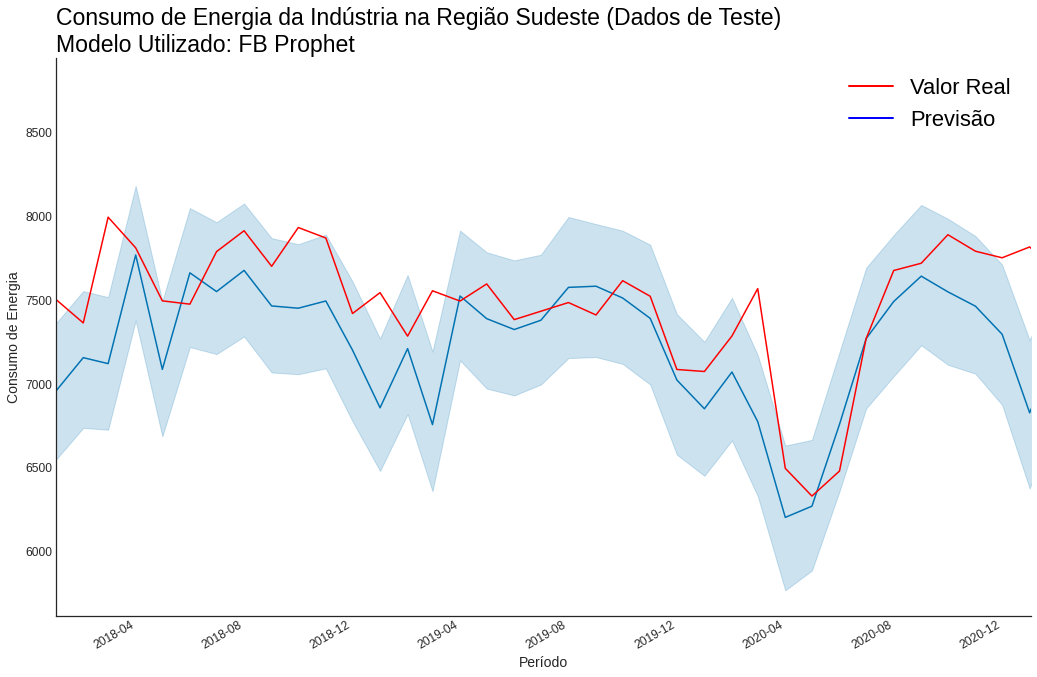

In [152]:
# plot
fig = modelo_prophet.plot(previsao, xlabel = 'Período', ylabel = 'Consumo de Energia')
ax = fig.gca()
fig.set_size_inches(15, 10)
ax.set_xlim(pd.to_datetime(['2018-01-01', '2021-01-02']))
dados_se_teste['ind_se'].plot(color = 'r', label = 'Valor Real')
plt.title('Consumo de Energia da Indústria na Região Sudeste (Dados de Teste)\nModelo Utilizado: FB Prophet', loc = 'left', fontsize = 23)
custom_lines = [Line2D([0], [0], color = 'r', lw = 2), Line2D([0], [0], color = 'b', lw = 2)]
plt.legend(custom_lines, ['Valor Real', 'Previsão'], fontsize = 22)
sns.despine()
plt.show()

In [153]:
# calcula as métricas utilizadas
mae_prophet = mean_absolute_error(ind_teste['y'].values, previsao['yhat'].values)
mse_prophet = mean_squared_error(ind_teste['y'].values, previsao['yhat'].values)
rmse_prophet = np.sqrt(mse_prophet)

print('MAE usando o modelo FBProphet: {:,.2f}'.format(mae_prophet))
print('MSE usando o modelo FBProphet: {:,.2f}'.format(mse_prophet))
print('O Root Mean Squared Error (RMSE) da previsão foi de {}'.format(round(rmse_prophet, 5)))

MAE usando o modelo FBProphet: 294.65
MSE usando o modelo FBProphet: 149,116.38
O Root Mean Squared Error (RMSE) da previsão foi de 386.1559


## Modelo 03: VAR

O modelo VAR (Vector Autoregression) é um modelo estatístico de previsão de séries temporais multivariadas, como é o caso da nossa série temporal. Ele necessita que as séries estejam estacionárias, ou seja, que tenham média constante ao longo do tempo.

In [154]:
# dados que serão utilizados
dados_se_var = dados_se[['ind_se', 'pim_se']]

As séries devem ser estacionárias. Para torná-las estacionárias, vamos utilizar a diferenciação. Também iremos medir se elas estão estacionárias através do Teste de Dickey-Fuller aumentado.

In [47]:
# diferenciação para transformar as séries em estacionárias
data_d = dados_se_var.diff()

In [155]:
# testando se a série do consumo de energia já está estacionária
adfuller_test = adfuller(data_d.ind_se.loc['02-02-2004':'02-01-2021'], autolag = "AIC")
print("ADF: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF: -3.6086695980813674
p-value: 0.00559743038490859


In [156]:
# testando se a série do produção da indústria já está estacionária
adfuller_test = adfuller(data_d.pim_se.loc['02-02-2004':], autolag = "AIC")
print("ADF: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF: -4.030002099368079
p-value: 0.0012613078960103127


As séries ainda não passou nos teste estatísticos que indicam que ela é estacionária, pois ainda possuem um baixo ```p_value```. Fazemos novamente a diferenciação.

In [157]:
dados_d = data_d.diff()

In [158]:
# testando se a série do consumo de energia já está estacionária
adfuller_test = adfuller(dados_d.ind_se.loc['03-01-2004':'02-01-2021'], autolag = "AIC")
print("ADF: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF: -13.539612454483263
p-value: 2.5281454930911374e-25


In [52]:
# testando se a série do produção da indústria já está estacionária
adfuller_test = adfuller(dados_d.pim_se.loc['03-01-2004':], autolag = "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -12.05739687574338
p-value: 2.514953753464114e-22


Agora ela está estacionário (com p-values significativos).

In [159]:
# separado os dados para o modelo
dados_var_treino = dados_d.loc['03-01-2004':'12-01-2017']
dados_var_teste = dados_d.loc['01-01-2018':'02-01-2021']

In [160]:
# inicializando o modelo
modelo_VAR = VAR(dados_var_treino)

# testando alguns parâmetros
results_aic = []
for p in range(1, 10):
    results = modelo_VAR.fit(p)
    results_aic.append(results.aic)

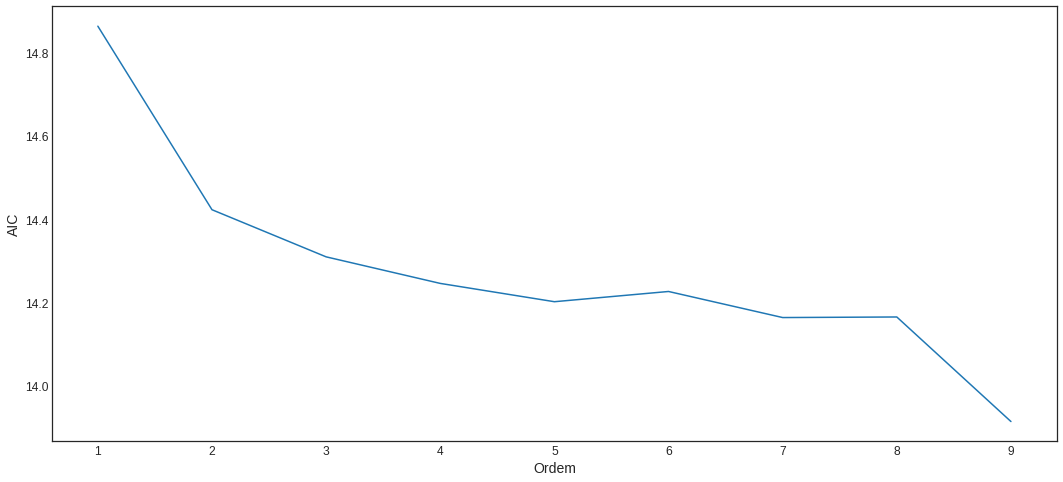

In [161]:
# fazendo a plotagem dos parâmetros
# queremos o que dá um menor AIC
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Ordem")
plt.ylabel("AIC")
plt.show()

# menor AIC é o de tamanho 9

In [167]:
# usando o parâmetro 9 obtido acima
results = modelo_VAR.fit(9)

In [168]:
# realizando a previsão
lag_order = results.k_ar
fc = results.forecast(dados_var_teste.values[-lag_order:], 9)

In [170]:
# organizando o dataframe como os dados obtidos
# fonte: https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36
df_forecast = pd.DataFrame(fc, index = dados_var_teste.index[-9:], columns = dados_var_teste.columns + '_f')
df_fc = df_forecast.copy()
columns = dados_var_treino.columns
for col in columns:
     df_fc[str(col)+'_forecast'] = dados_var_treino[col].iloc[-1] + df_fc[str(col)+'_f'].cumsum()
for col in columns:
     df_fc[str(col)+'_first_differenced'] = (dados_var_treino[col].iloc[-1]- dados_var_treino[col].iloc[-2]) + df_fc[str(col)+'_f'].cumsum()
     df_fc[str(col)+'_forecast'] = dados_var_treino[col].iloc[-1] + df_fc[str(col)+'_first_differenced'].cumsum()
df_results = df_fc

In [171]:
# calculando as métricas
forecast = df_results['ind_se_forecast'].values
actual = dados_var_teste['ind_se'].iloc[-9:].values

mae_var = mean_absolute_error(forecast, actual)
mse_var = mean_squared_error(forecast, actual)
rmse_var = np.sqrt(mse_var)

print('MAE do modelo VAR: ', mae_var)
print('MSE do modelo VAR: ', mse_var)
print('RMSE do modelo VAR', rmse_var)

MAE do modelo VAR:  2774.0414771135775
MSE do modelo VAR:  9314276.158410938
RMSE do modelo VAR 3051.929907191667


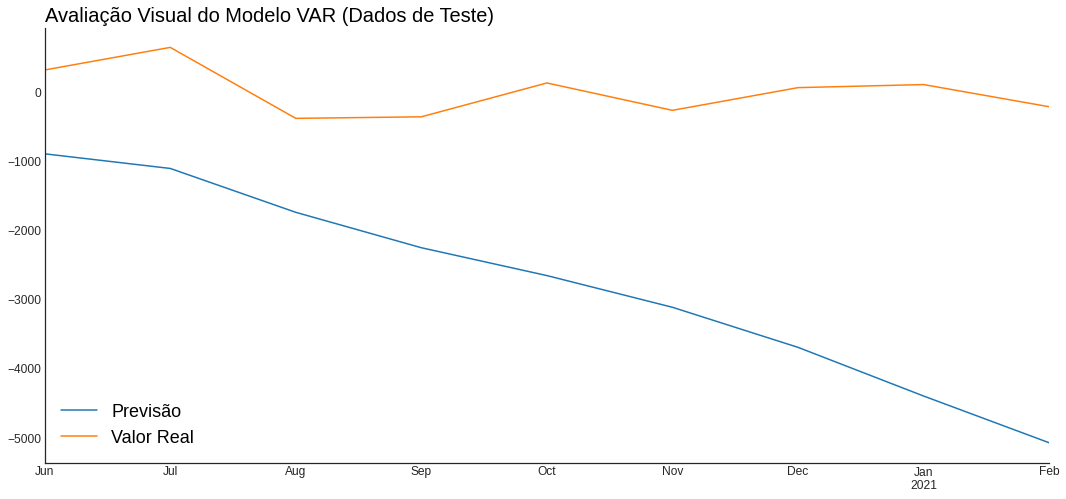

In [172]:
# plotagem da previsão
# obs: as séries estão transformadas em estacionárias
df_results['ind_se_forecast'].plot(label = 'Previsão')
dados_var_teste['ind_se'].iloc[-9:].plot(label = 'Valor Real')
plt.title('Avaliação Visual do Modelo VAR (Dados de Teste)', loc = 'left', fontsize = 20)
sns.despine()
plt.legend(fontsize = 18)
plt.show()

Percebemos que esse modelo é pouco adequado para ser utilizado nesse caso, sofrendo de _underfitting_ nos dados de teste e com métricas com valores não muito bons, se comparado aos dois modelos anteriores.

## Modelo 04: LSTM

LSTM (Long Short Term Memory) é um poderoso modelo de rede neural recorrente (RNN). Seu uso não é exclusivo para séries temporais, mas suas características como uma "memória" persistente o tornam relevantes para esse problema.

Vamos usar as features ```ind_se``` e ```pim_se``` para o modelo.

In [173]:
# preparando os dados
dados_lstm_treino = dados_se_treino[['ind_se']].copy()
dados_lstm_teste = dados_se_teste[['ind_se']].copy()

In [174]:
# vamos normalizar as features
scaler = MinMaxScaler(feature_range = (-1, 1))
scaler.fit_transform(dados_lstm_treino)
scaled_dados_lstm_treino = scaler.transform(dados_lstm_treino)
scaled_dados_lstm_teste = scaler.transform(dados_lstm_teste)

In [175]:
# criando os dados supervisionados com 48 inputs e 1 output
n_lag = 48
X_train = []
y_train = []
for i in range(n_lag, len(dados_lstm_treino)):
    X_train.append(scaled_dados_lstm_treino[i-n_lag:i, 0])
    y_train.append(scaled_dados_lstm_treino[i, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Reshape do conjunto de treino
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [179]:
# iniciando o modelo
modelo_lstm = Sequential()
 
# Primeira Layer
modelo_lstm.add(LSTM(128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
modelo_lstm.add(Dense(25))

# Segunda Layer
modelo_lstm.add(LSTM(64, return_sequences=False))

# Output Layer
modelo_lstm.add(Dense(units=1))
 
# compilar o modelo
modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
# fit do modelo nos dados de treino
modelo_lstm.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_split = 0.2)

Epoch 1/200
6/6 [==============================] - 5s 273ms/step - loss: 0.2808 - val_loss: 0.1293
Epoch 2/200
6/6 [==============================] - 0s 70ms/step - loss: 0.1580 - val_loss: 0.0965
Epoch 3/200
6/6 [==============================] - 0s 80ms/step - loss: 0.1468 - val_loss: 0.0991
Epoch 4/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1128 - val_loss: 0.0929
Epoch 5/200
6/6 [==============================] - 0s 85ms/step - loss: 0.1648 - val_loss: 0.0894
Epoch 6/200
6/6 [==============================] - 0s 80ms/step - loss: 0.1405 - val_loss: 0.0885
Epoch 7/200
6/6 [==============================] - 1s 86ms/step - loss: 0.1051 - val_loss: 0.0917
Epoch 8/200
6/6 [==============================] - 0s 80ms/step - loss: 0.1208 - val_loss: 0.0981
Epoch 9/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1584 - val_loss: 0.1013
Epoch 10/200
6/6 [==============================] - 0s 66ms/step - loss: 0.1022 - val_loss: 0.1032
Epoch 11/200
6/6 [

In [180]:
# preparando os dados de teste
inputs = dados_se_teste[-n_lag:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []

for i in range(n_lag, n_lag+len(dados_lstm_teste)):
    X_test.append(inputs[i-n_lag:i, 0])
     
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 
# previsão
predict_scaled = modelo_lstm.predict(X_test)
predict = scaler.inverse_transform(predict_scaled)
 
predict = pd.DataFrame(predict)
predict.columns = ['ind_se']
predict.index = dados_lstm_teste.index

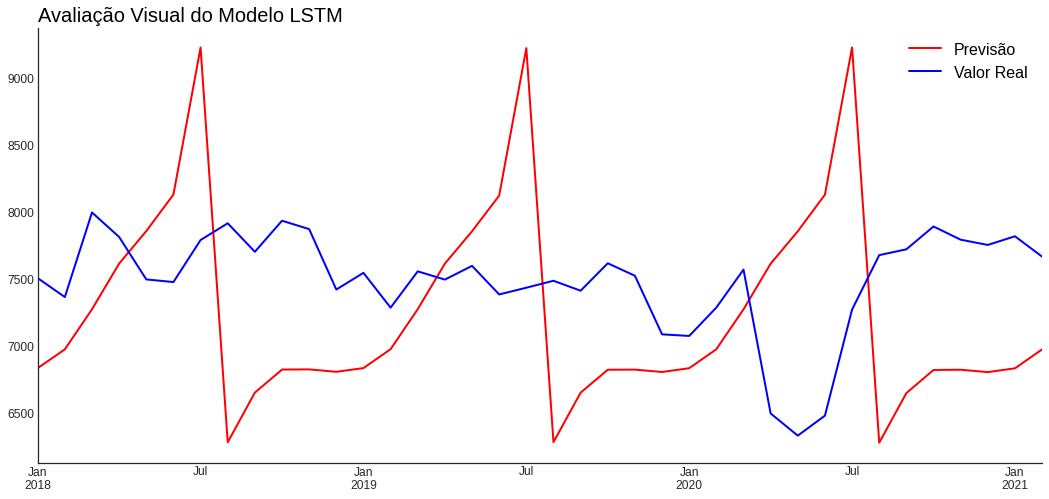

In [181]:
# plot da previsão
predict.ind_se.plot(color = 'r', label = 'Previsão', linewidth = 2)
dados_se_teste.ind_se.plot(color = 'b', label = 'Valor Real', linewidth = 2)
plt.title('Avaliação Visual do Modelo LSTM', fontsize = 20, loc = 'left')
plt.legend(fontsize = 16)
sns.despine()
plt.show()

In [182]:
# calculando as métricas
forecast_lstm = predict.ind_se.values
actual_lstm = dados_se_teste.ind_se.values

mae_lstm = mean_absolute_error(forecast_lstm, actual_lstm)
mse_lstm = mean_squared_error(forecast_lstm, actual_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print('MAE do modelo LSTM: ', mae_lstm)
print('MSE do modelo LSTM: ', mse_lstm)
print('RMSE do modelo LSTM: ', rmse_lstm)

MAE do modelo LSTM:  843.3326147861842
MSE do modelo LSTM:  943528.9185613099
RMSE do modelo LSTM:  971.3541674185117


Esse modelo conseguiu se adaptar pouco aos dados de teste. Uma razão foi não termos utilizados os dados da produção industrial para auxiliar na previsão. Além disso, não tenho tanto conhecimento ainda nesse tipo de modelo com redes neurais para realizar uma melhor escolha dos parâmetros.

## Modelo 05: XGBoost

O modelo XGBoost (Extreme Gradient Boosting) é uma implementação poderosa (ou "extrema") do algoritmo de gradient boosting. Não é um modelo específico para séries temporais, mas sua versatilidade e bons resultados o tornam um bom candidato para resolver a versão supervisionada de séries temporais.

In [183]:
# fonte: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['data'] = df.index
    df['dia_da_semana'] = df['data'].dt.dayofweek
    df['quarter'] = df['data'].dt.quarter
    df['mes'] = df['data'].dt.month
    df['ano'] = df['data'].dt.year
    
    X = df[['dia_da_semana', 'quarter', 'mes','ano', 'pim_se']]
    if label:
        y = df[label]
        return X, y
    return X

In [184]:
# preparando os dados
dados_xgb_treino = dados_se_treino[['ind_se', 'pim_se']]
dados_xgb_teste = dados_se_teste[['ind_se', 'pim_se']]

In [185]:
# split dos dados
X_train, y_train = create_features(dados_xgb_treino, label = 'ind_se')
X_test, y_test = create_features(dados_xgb_teste, label = 'ind_se')

Após a busca por parâmetros, o modelo padrão performou melhor e seguiremos com ele.

In [186]:
modelo_xgb = xgb.XGBRegressor(n_estimators = 1000)
modelo_xgb.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50, verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

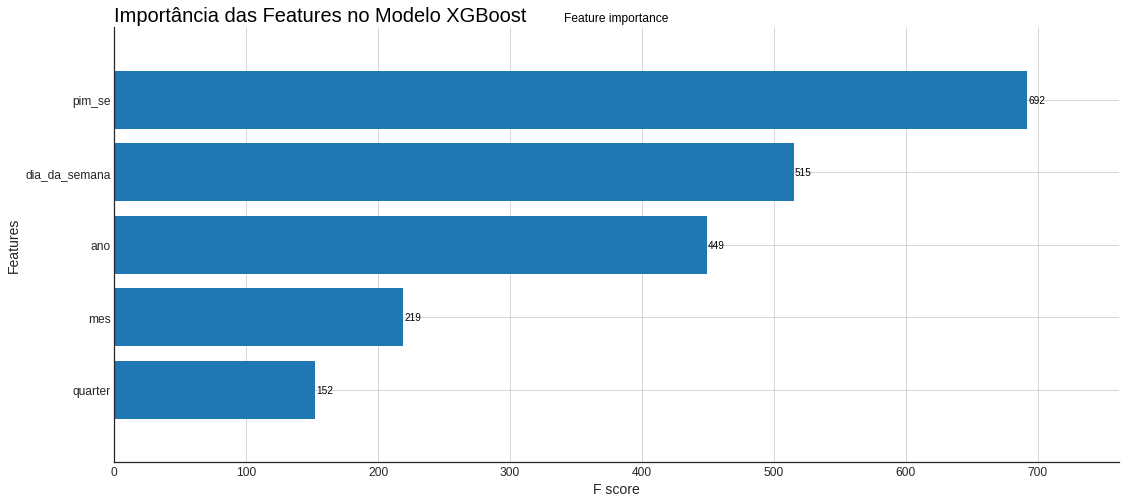

In [191]:
plot_importance(modelo_xgb, height = 0.8)
plt.title('Importância das Features no Modelo XGBoost', fontsize = 20, loc = 'left')
sns.despine()
plt.show()

In [193]:
# preparaco dos dados de teste e previsão
dados_xgb_teste['previsao'] = modelo_xgb.predict(X_test)
dados_xgb = pd.concat([dados_xgb_treino, dados_xgb_teste], sort = False)

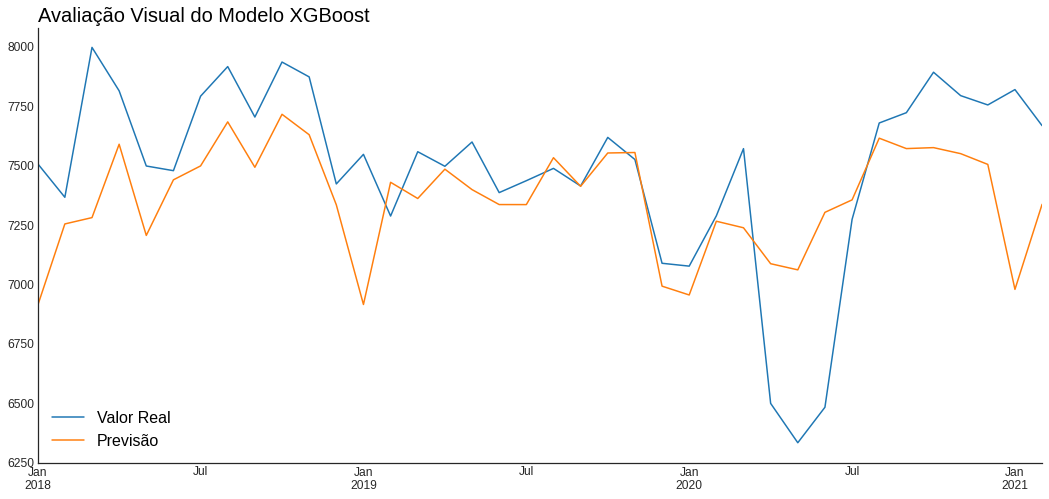

In [196]:
# plot da previsão
dados_xgb_teste[['ind_se', 'previsao']].plot()
plt.title('Avaliação Visual do Modelo XGBoost', fontsize = 20, loc = 'left')
sns.despine()
plt.legend(labels = ['Valor Real', 'Previsão'], fontsize = 16)
plt.show()

In [197]:
# cálculo das métricas
previsao_xgb = dados_xgb_teste.previsao.values
real = dados_xgb_teste.ind_se.values

mae_xgb = mean_absolute_error(previsao_xgb, real)
mse_xgb = mean_squared_error(previsao_xgb, real)
rmse_xgb = np.sqrt(mse_xgb)

print('MAE do modelo XGBoost: ', mae_xgb)
print('MSE do modelo XGBoost: ', mse_xgb)
print('RMSE do modelo XGBoost: ', rmse_xgb)

MAE do modelo XGBoost:  256.2379816899671
MSE do modelo XGBoost:  120959.85054355982
RMSE do modelo XGBoost:  347.7928270444343


O modelo com os parâmetros 'default' teve melhor performance, mesmo após eu ter feito um teste utilizando o GridSearch para os parâmetros.

## Modelo 06: SVR

O modelo de SVR (Support Vector Regression) é a versão "de regressão" do Support Vector Machine. Novamente, não é um modelo específico de séries temporais, mas que pode ser aplicado com algumas adaptações nos dados.

In [199]:
# preparado os dados
dados_svr_treino = dados_se_treino[['ind_se', 'pim_se']]
dados_svr_teste = dados_se_teste[['ind_se', 'pim_se']]

In [200]:
X_train, y_train = create_features(dados_svr_treino, label = 'ind_se')
X_test, y_test = create_features(dados_svr_teste, label = 'ind_se')

In [201]:
# instanciando o modelo
modelo_svr = SVR()

# busca pelos melhores parâmetros
teste_parametros = [{'degree':[1, 4, 6], 'epsilon':[0.3, 0.6, 0.9],
                    'C':[1, 3, 6, 9], 'kernel':['linear', 'sigmoid']}]

modelo_svr_search = GridSearchCV(modelo_svr, teste_parametros,
                                scoring = 'neg_mean_squared_error',
                                error_score = 'raise', cv = 5)

modelo_svr_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=SVR(),
             param_grid=[{'C': [1, 3, 6, 9], 'degree': [1, 4, 6],
                          'epsilon': [0.3, 0.6, 0.9],
                          'kernel': ['linear', 'sigmoid']}],
             scoring='neg_mean_squared_error')

In [202]:
# quais os parâmetros escolhidos?
modelo_svr_search.best_params_

{'C': 1, 'degree': 1, 'epsilon': 0.9, 'kernel': 'linear'}

In [203]:
# iniciando o modelo com os melhor parâmetros
modelo_svr = modelo_svr_search.best_estimator_

In [204]:
# fit do modelo nos dados de treino
modelo_svr.fit(X_train, y_train)
# previsão nos dados de teste
predictions_svr = modelo_svr.predict(X_test)

# cálculo das métricas
mae_svr = mean_absolute_error(y_test, predictions_svr)
mse_svr = mean_squared_error(y_test, predictions_svr)
rmse_svr = np.sqrt(mse_svr)

print('MAE do modelo SVR: ', mae_svr)
print('MSE do modelo SVR: ', mse_svr)
print('RMSE do modelo SVR: ', rmse_svr)

MAE do modelo SVR:  268.2383245516975
MSE do modelo SVR:  109439.69386908058
RMSE do modelo SVR:  330.81670736085954


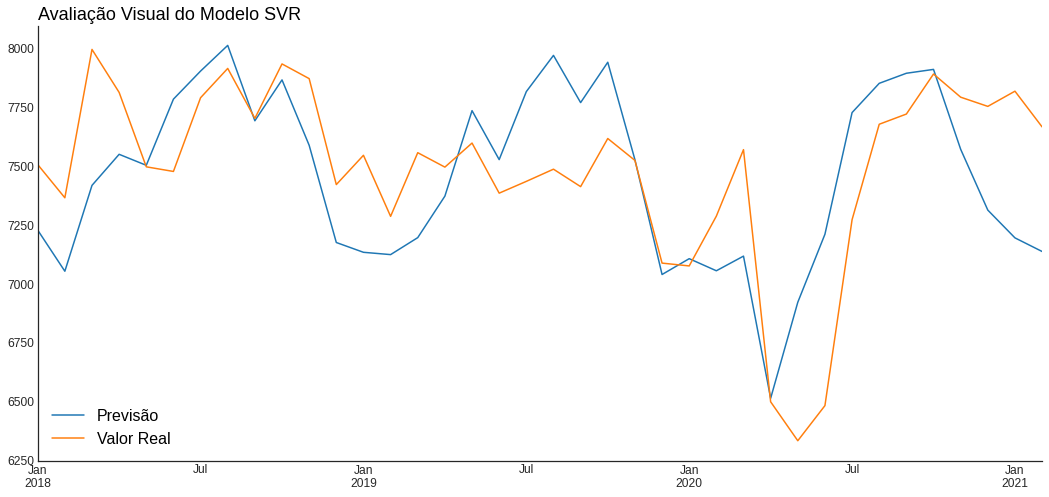

In [206]:
# plot da previsão
preds_svr = pd.DataFrame(predictions_svr)
y_test_df = pd.DataFrame(y_test)
preds_svr.columns = ['ind_se']
preds_svr.index = y_test.index
preds_svr.columns = ['ind_se_pred']
full = pd.concat((preds_svr, y_test), axis = 1)
full.plot()
plt.title('Avaliação Visual do Modelo SVR', fontsize = 18, loc = 'left')
sns.despine()
plt.legend(labels =  ['Previsão', 'Valor Real'], fontsize = 16)

## Modelos Extra: Lazy Predict

O modelo de SVR (Support Vector Regression) é a versão "de regressão" do Support Vector Machine. Novamente, não é um modelo específico de séries temporais, mas que pode ser aplicado com algumas adaptações nos dados.

Não irei utilizar nenhum modelo daqui para avaliação, fiz essa parte _"just for fun"_.

In [207]:
# preparação dos dados
X_train = dados_se_treino.drop(['ind_se'], axis = 1)
y_train = dados_se_treino['ind_se']

X_test = dados_se_teste.drop(['ind_se'], axis = 1)
y_test = dados_se_teste['ind_se']

In [208]:
# inicialização do modelo
reg = LazyRegressor(verbose = 0, ignore_warnings = False, custom_metric = None)

# fit e previsão
models, predictions_lazy = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


In [209]:
# vamos observar os resultados dos modelos
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PassiveAggressiveRegressor,0.34,0.53,258.97,0.02
ElasticNetCV,0.28,0.49,270.23,0.10
LassoLars,0.25,0.47,275.93,0.02
ElasticNet,0.23,0.46,279.56,0.02
LassoLarsIC,0.20,0.44,283.76,0.02
LassoCV,0.18,0.42,288.65,0.19
LarsCV,0.13,0.39,296.43,0.06
LassoLarsCV,0.09,0.36,303.64,0.06
OrthogonalMatchingPursuitCV,0.07,0.34,307.21,0.02


Tivemos alguns resultados bem relevantes acima para a métrica RMSE. Novamente, não irei validar esses modelos por falta de tempo.

## Conclusões

In [210]:
# preparar um resumo das métricas
resultados_metricas = {
    'Modelo': ['Dummy', 'SARIMA', 'Prophet', 'VAR', 'LSTM', 'XGBoost', 'SVR'],
    'MAE': [mae_dummy, mae_sarima, mae_prophet, mae_var, mae_lstm, mae_xgb, mae_svr],
    'MSE': [mse_dummy, mse_sarima, mse_prophet, mse_var, mse_lstm, mse_xgb, mse_svr],
    'RMSE' : [rmse_dummy, rmse_sarima, rmse_prophet, rmse_var, rmse_lstm, rmse_xgb, rmse_svr]
}

In [211]:
resultados_metricas_df = pd.DataFrame(resultados_metricas)
resultados_metricas_df

,Modelo,MAE,MSE,RMSE
0,Dummy,302.44,124692.91,353.12
1,SARIMA,314.37,205634.48,453.47
2,Prophet,294.65,149116.38,386.16
3,VAR,2774.04,9314276.16,3051.93
4,LSTM,843.33,943528.92,971.35
5,XGBoost,256.24,120959.85,347.79
6,SVR,268.24,109439.69,330.82


In [91]:
# salvar externamente
resultados_metricas_df.to_excel('resultados_metricas_modelos.xlsx', index = False)

# descomentar a linha abaixo para realizar o download
# files.download('resultados_metricas_modelos.xlsx')

Aqui entra a questão de qual métrica escolher para a validação do modelo. [Fonte: Evaluating Forecast Accuracy](https://otexts.com/fpp2/accuracy.html)

Observando a tabela acima, tanto o modelo XGBoost e o SVR tiveram o melhor desempenho em MAE e RMSE, respectivamente.

Escolhi como métrica o Root Mean Squared Error (RMSE) por ela dar um maior peso a erros maiores. Além disso, apenas fazendo uma análise gráfica entre as previsões do modelo XGBoost e SVR, o modelo XGBoost "peca" para baixo, enquanto que o modelo SVR "peca" para cima, ou seja, suas previsões estão acima dos valores reais. Em um contexto como o que estamos tratando, de previsão do consumo de energia elétrica, é imprescindível que não erremos "para baixo" do valor real, pois isso implicaria em falta de energia fornecidada para a distruibuição.

In [212]:
# preparando um dataframe com todas as previsões nos dados de teste
prev_prophet = pd.DataFrame(previsao['yhat'])
prev_prophet.index = dados_se_teste.index

previsoes_dados_de_teste = pd.DataFrame(
    {
        'Valor Real': dados_se_teste.ind_se,
        'Dummy': dados_se_dummy_teste.pim_se_rescaled,
        'SARIMA': previsao_arima.predicted_mean,
        'Prophet': prev_prophet.yhat,
        'VAR': df_results['ind_se_forecast'],
        'LSTM': predict.ind_se,
        'XGBoost': dados_xgb.loc['01-01-2018':'02-01-2021'].previsao,
        'SVR': preds_svr.ind_se_pred
    }
)

[]

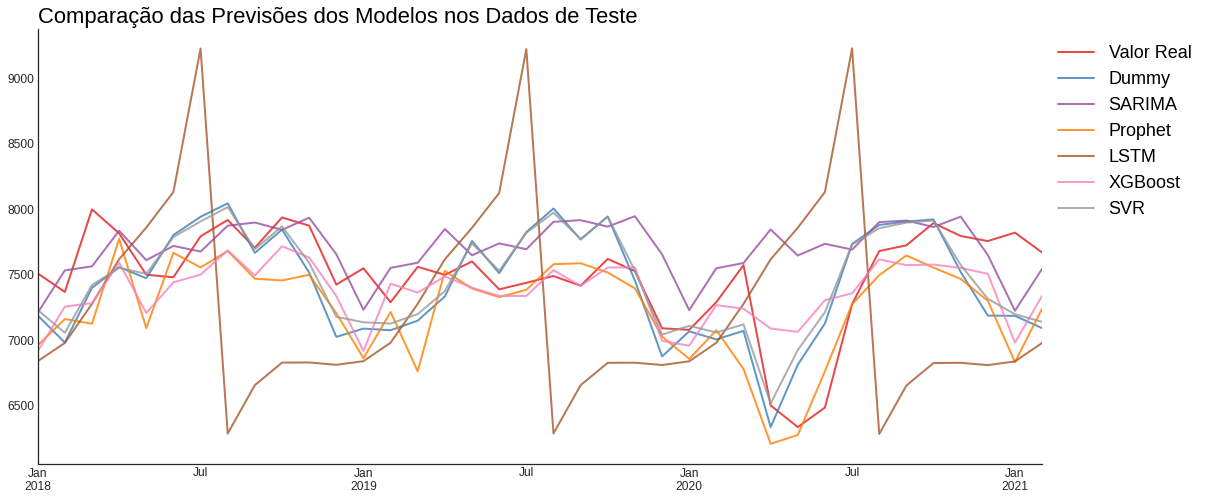

In [213]:
# plot para comparação dos modelos
# removi o modelo VAR pela normalização dos dados
previsoes_dados_de_teste.drop('VAR', axis = 1).plot(linewidth = 2, alpha = 0.8, colormap = 'Set1')
plt.title('Comparação das Previsões dos Modelos nos Dados de Teste', fontsize = 22, loc = 'left')
plt.legend(fontsize = 18, bbox_to_anchor = (1, 1), loc = 'upper left')
sns.despine()
plt.plot()

[]

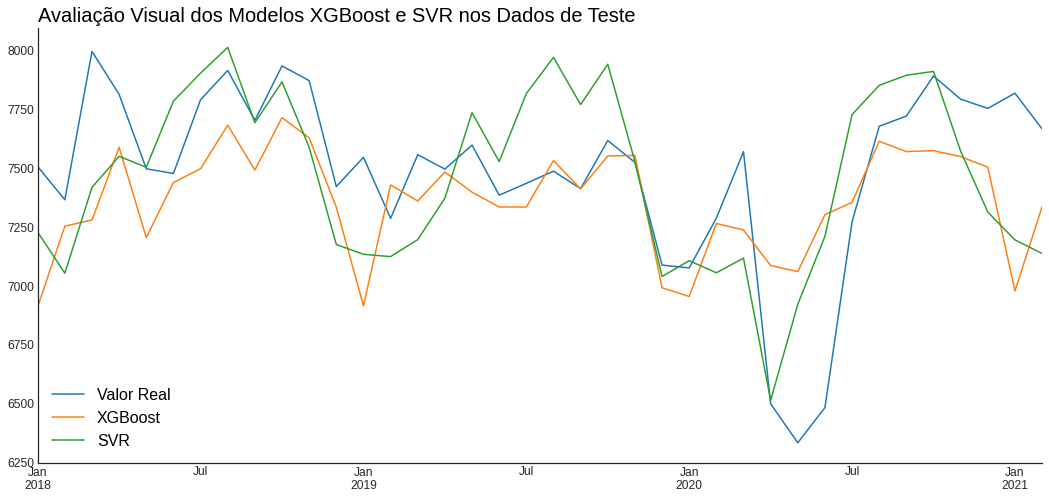

In [215]:
# plot dos dois melhores modelos
previsoes_dados_de_teste[['Valor Real', 'XGBoost', 'SVR']].plot()
plt.title('Avaliação Visual dos Modelos XGBoost e SVR nos Dados de Teste', fontsize = 20, loc = 'left')
plt.legend(fontsize = 16)
sns.despine()
plt.plot()

# Previsão Para os Próximos 2 Anos

Como o modelo escolhido foi o SVR, iremos aplicá-lo para a previsão.

Já temos os melhores parâmetros calculados anteriormente, vamos agora só adaptar os dados e realizar a previsão.

In [216]:
# ajuste dos dados
dados_svr_previsao = dados_se_previsao[['ind_se', 'pim_se']]
dados_svr_previsao = dados_se_previsao[['ind_se', 'pim_se']]

In [217]:
X_previsao, y_previsao = create_features(dados_svr_previsao, label = 'ind_se')

In [218]:
# previsão com o modelo SVR
previsao_proximos_2_anos = modelo_svr.predict(X_previsao)

In [219]:
# preparação de um dataframe com os dados da previsão
previsao_2_anos = pd.DataFrame(previsao_proximos_2_anos)
previsao_2_anos.index = dados_se_previsao.index
previsao_2_anos.columns = ['ind_se']

In [220]:
# salvar externamente
previsao_2_anos.to_excel('previsao_proximos_2_anos.xlsx', index = True)

# descomentar a linha abaixo para realizar o download
# files.download('previsao_proximos_2_anos.xlsx')

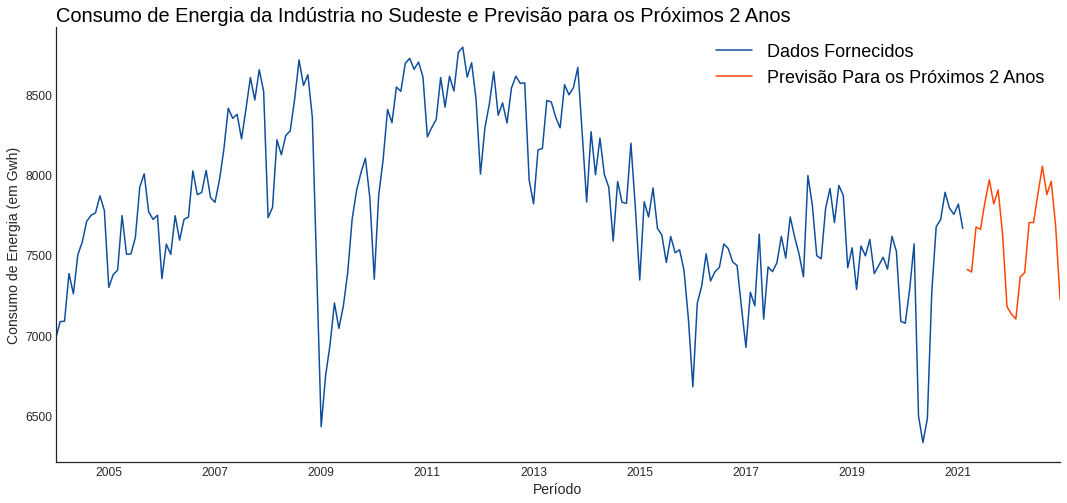

In [223]:
# plot com a previsão
dados_se.ind_se.plot(color = BLUE1, label = 'Dados Fornecidos')
previsao_2_anos.ind_se.plot(color = 'orangered', label = 'Previsão Para os Próximos 2 Anos')
plt.title('Consumo de Energia da Indústria no Sudeste e Previsão para os Próximos 2 Anos', fontsize = 20, loc = 'left')
plt.legend(fontsize = 18)
plt.ylabel('Consumo de Energia (em Gwh)')
plt.xlabel('Período')
sns.despine()
plt.show()

# Referências

# Contatos